# Predicting the beautiful game, with a game of the beautiful game

## Premier League Match Predictions with FIFA game data

Ever since playing the beautiful game as a child, watching my first football game of Liverpool FC and my first world cup in 1998, the game has not stopped fascinating me. Not surprisingly, this has also led to a fascination with the FIFA football game. The data collected by EA Sports for the FIFA football game has been ever expanding and becoming increasingly real time. Player and team statistics used to be updated once a year with the new game release, but nowadays, player and team statistics get updated regularly during the season, reflecting players and teams in and out of form, as well as new players emerging during the season. <br>

With the increasing close to real time data collected for the FIFA football game, I pose the question whether it is possible to predict the outcome of a match, based on data from the FIFA football game?

As a premise we put ourselves in the shoes of many football fans out there.
We are sitting in front of our game console, playing the latest FIFA game. It's one hour before kickoff of the match of our favorite Premier League football team. As usual, the team news for both teams has just been released.
Can we predict the outcome of the Premier League match, based on the FIFA game statistics of the announced starting eleven of both sides?

Before we can answer this question, we will have to prepare the data for analysis, which will be part 1 of this notebook.<br>

Part two will then continue with Exploratory Data Analysis, to gain some insights from the data. After we will run several machine learning algorithms, to try to predict the outcome of the game.


## Part 1 Data Pre-processing

Before we can start, we will first need a dataset. For this project I will be using the "European Soccer Database". <br>
The dataset can be found under the following link on Kaggle: [Dataset](https://www.kaggle.com/hugomathien/soccer)

The dataset contains match information for 25,000 matches, spanning seasons 2008/2009 to 2015/2016. In addition, it contains the player and team data for the same seasons from the FIFA football game. As the data is saved on an SQL database, in the first part of the next section we will extract the data from the database, before merging the match, player and team information into one data frame.

### Data Extraction from SQLlite Database
For the data extraction in SQL, I will be using the sqlite3 library. This offers a seamless transition from SQL to pandas, as we can directly extract the data from the database with sql queries into a Pandas Dataframe.


In [1]:
import pandas as pd # data processing
import sqlite3 #SQL library to extract data from sql database

#display max columns and rows, to be able to inspect big data tables
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Below line is to connect the google colab instance to google drive. If run outside colab, below code is ignored.

In [2]:
# conntects to google drive if ran in colab
# ignored if ran outside of colab

if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

The following code first connects to the SQL database saved in the folder under the 'path' variable in case it is ran within colab. If ran outside of colab, the SQL database should be saved in the same folder as the notebook.

In [3]:
# connect to SQL database in google drive if ran in colab. 
# connet to SQL database in notebook folder if ran outside of colab

if 'google.colab' in str(get_ipython()):
    path = '/content/drive/My Drive/Colab Notebooks/Python_Data_Programming_Coursework/'
else:
    path = str()
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

The next few lines of code first extract an overview of all tables in the database. Then I download the tables from the SQL database into a dataframe with the sqlite3 library.

It may be possible to extract the data in a more efficient manner, merging several tables during the extraction. However, as the SQL query code would get involved, I decided to do most of the table merging activity in Pandas.

For the "Match" table, in the first download I only extract five entries, to get an understanding of the column structure. This is the base table which will be used to merge the player and team data on.

In [4]:
# get overview of tables in SQL database
tables = pd.read_sql("""SELECT *
                      FROM sqlite_master
                      WHERE type='table';""", conn)
tables

type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         4   
1  table  Player_Attributes  Player_Attributes        11   
2  table             Player             Player        14   
3  table              Match              Match        18   
4  table             League             League        24   
5  table            Country            Country        26   
6  table               Team               Team        29   
7  table    Team_Attributes    Team_Attributes         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...  
2  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...  
3  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...  
4  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...  
5  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...  
6  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...  
7  CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...

In [5]:
# extract Country table from database
countries = pd.read_sql("""SELECT *
                        FROM Country
                        """, conn)
countries

id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland

In [6]:
# extract League table from database
leagues = pd.read_sql("""SELECT *
                      FROM League
                       """, conn)
leagues

id  country_id                      name
0       1           1    Belgium Jupiler League
1    1729        1729    England Premier League
2    4769        4769            France Ligue 1
3    7809        7809     Germany 1. Bundesliga
4   10257       10257             Italy Serie A
5   13274       13274    Netherlands Eredivisie
6   15722       15722        Poland Ekstraklasa
7   17642       17642  Portugal Liga ZON Sagres
8   19694       19694   Scotland Premier League
9   21518       21518           Spain LIGA BBVA
10  24558       24558  Switzerland Super League

In [7]:
# extract Team table from database
teams = pd.read_sql("""SELECT *
                        FROM Team
                        """, conn)
teams.head(5)

id  team_api_id  team_fifa_api_id     team_long_name team_short_name
0   1         9987             673.0           KRC Genk             GEN
1   2         9993             675.0       Beerschot AC             BAC
2   3        10000           15005.0   SV Zulte-Waregem             ZUL
3   4         9994            2007.0   Sporting Lokeren             LOK
4   5         9984            1750.0  KSV Cercle Brugge             CEB

In [8]:
# extract Team Attributes table from database
team_attributes = pd.read_sql("""SELECT *
                        FROM Team_Attributes
                        """, conn)
team_attributes.head(5)

id  team_fifa_api_id  team_api_id                 date  buildUpPlaySpeed  \
0   1               434         9930  2010-02-22 00:00:00                60   
1   2               434         9930  2014-09-19 00:00:00                52   
2   3               434         9930  2015-09-10 00:00:00                47   
3   4                77         8485  2010-02-22 00:00:00                70   
4   5                77         8485  2011-02-22 00:00:00                47   

  buildUpPlaySpeedClass  buildUpPlayDribbling buildUpPlayDribblingClass  \
0              Balanced                   NaN                    Little   
1              Balanced                  48.0                    Normal   
2              Balanced                  41.0                    Normal   
3                  Fast                   NaN                    Little   
4              Balanced                   NaN                    Little   

   buildUpPlayPassing buildUpPlayPassingClass buildUpPlayPositioningClass  \
0                  50                   Mixed                   Organised   
1                  56                   Mixed                   Organised   
2                  54                   Mixed                   Organised   
3                  70                    Long                   Organised   
4                  52                   Mixed                   Organised   

   chanceCreationPassing chanceCreationPassingClass  chanceCreationCrossing  \
0                     60                     Normal                      65   
1                     54                     Normal                      63   
2                     54                     Normal                      63   
3                     70                      Risky                      70   
4                     53                     Normal                      48   

  chanceCreationCrossingClass  chanceCreationShooting  \
0                      Normal                      55   
1                      Normal                      64   
2                      Normal                      64   
3                        Lots                      70   
4                      Normal                      52   

  chanceCreationShootingClass chanceCreationPositioningClass  defencePressure  \
0                      Normal                      Organised               50   
1                      Normal                      Organised               47   
2                      Normal                      Organised               47   
3                        Lots                      Organised               60   
4                      Normal                      Organised               47   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0               Medium                 55                  Press   
1               Medium                 44                  Press   
2               Medium                 44                  Press   
3               Medium                 70                 Double   
4               Medium                 47                  Press   

   defenceTeamWidth defenceTeamWidthClass defenceDefenderLineClass  
0                45                Normal                    Cover  
1                54                Normal                    Cover  
2                54                Normal                    Cover  
3                70                  Wide                    Cover  
4                52                Normal                    Cover

In [9]:
# extract Match table from database, limited to 5 matches, just to get a quick understanding of the table. 
matches = pd.read_sql("""SELECT *
                        FROM Match
                        JOIN Country ON Match.country_id = Country.id
                        WHERE Country.name = 'England'
                        LIMIT 5
                        """, conn)
matches

id  country_id  league_id     season  stage                 date  \
0  1729        1729       1729  2008/2009      1  2008-08-17 00:00:00   
1  1730        1729       1729  2008/2009      1  2008-08-16 00:00:00   
2  1731        1729       1729  2008/2009      1  2008-08-16 00:00:00   
3  1732        1729       1729  2008/2009      1  2008-08-16 00:00:00   
4  1733        1729       1729  2008/2009      1  2008-08-17 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0        489042             10260             10261               1   
1        489043              9825              8659               1   
2        489044              8472              8650               0   
3        489045              8654              8528               2   
4        489046             10252              8456               4   

   away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0               1               1               2               4   
1               0               1               2               4   
2               1               1               2               4   
3               1               1               2               4   
4               2               1               2               4   

   home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0               6               8               2               4   
1               6               8               2               4   
2               6               8               2               4   
3               6               8               2               4   
4               6               8               2               4   

   home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0               6               8                4                6   
1               6               8                4                6   
2               6               8                4                6   
3               6               8                4                6   
4               6               8                4                6   

   away_player_X1  away_player_X2  away_player_X3  away_player_X4  \
0               1               2               4               6   
1               1               2               4               6   
2               1               2               4               6   
3               1               2               6               8   
4               1               2               4               6   

   away_player_X5  away_player_X6  away_player_X7  away_player_X8  \
0               8               2               4               6   
1               8               5               7               9   
2               8               2               4               6   
3               4               2               4               6   
4               8               1               3               5   

   away_player_X9  away_player_X10  away_player_X11  home_player_Y1  \
0               8                5                5               1   
1               1                3                5               1   
2               8                4                6               1   
3               8                4                6               1   
4               7                9                5               1   

   home_player_Y2  home_player_Y3  home_player_Y4  home_player_Y5  \
0               3               3               3               3   
1               3               3               3               3   
2               3               3               3               3   
3               3               3               3               3   
4               3               3               3               3   

   home_player_Y6  home_player_Y7  home_player_Y8  home_player_Y9  \
0               7               7               7               7   
1               7               7               7               7   
2  

In [10]:
# extract Player Attributes table from database
Player_Attributes = pd.read_sql("""SELECT *
                        FROM Player_attributes
                        """, conn)
Player_Attributes.head(5)

id  player_fifa_api_id  player_api_id                 date  overall_rating  \
0   1              218353         505942  2016-02-18 00:00:00            67.0   
1   2              218353         505942  2015-11-19 00:00:00            67.0   
2   3              218353         505942  2015-09-21 00:00:00            62.0   
3   4              218353         505942  2015-03-20 00:00:00            61.0   
4   5              218353         505942  2007-02-22 00:00:00            61.0   

   potential preferred_foot attacking_work_rate defensive_work_rate  crossing  \
0       71.0          right              medium              medium      49.0   
1       71.0          right              medium              medium      49.0   
2       66.0          right              medium              medium      49.0   
3       65.0          right              medium              medium      48.0   
4       65.0          right              medium              medium      48.0   

   finishing  heading_accuracy  short_passing  volleys  dribbling  curve  \
0       44.0              71.0           61.0     44.0       51.0   45.0   
1       44.0              71.0           61.0     44.0       51.0   45.0   
2       44.0              71.0           61.0     44.0       51.0   45.0   
3       43.0              70.0           60.0     43.0       50.0   44.0   
4       43.0              70.0           60.0     43.0       50.0   44.0   

   free_kick_accuracy  long_passing  ball_control  acceleration  sprint_speed  \
0                39.0          64.0          49.0          60.0          64.0   
1                39.0          64.0          49.0          60.0          64.0   
2                39.0          64.0          49.0          60.0          64.0   
3                38.0          63.0          48.0          60.0          64.0   
4                38.0          63.0          48.0          60.0          64.0   

   agility  reactions  balance  shot_power  jumping  stamina  strength  \
0     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
1     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
2     59.0       47.0     65.0        55.0     58.0     54.0      76.0   
3     59.0       46.0     65.0        54.0     58.0     54.0      76.0   
4     59.0       46.0     65.0        54.0     58.0     54.0      76.0   

   long_shots  aggression  interceptions  positioning  vision  penalties  \
0        35.0        71.0           70.0         45.0    54.0       48.0   
1        35.0        71.0           70.0         45.0    54.0       48.0   
2        35.0        63.0           41.0         45.0    54.0       48.0   
3        34.0        62.0           40.0         44.0    53.0       47.0   
4        34.0        62.0           40.0         44.0    53.0       47.0   

   marking  standing_tackle  sliding_tackle  gk_diving  gk_handling  \
0     65.0             69.0            69.0        6.0         11.0   
1     65.0             69.0            69.0        6.0         11.0   
2     65.0             66.0            69.0        6.0         11.0   
3     62.0             63.0            66.0        5.0         10.0   
4     62.0             63.0            66.0        5.0         10.0   

   gk_kicking  gk_positioning  gk_reflexes  
0        10.0             8.0          8.0  
1        10.0             8.0          8.0  
2        10.0             8.0          8.0  
3         9.0             7.0          7.0  
4         9.0             7.0          7.0

The below code forms our base match table, to later merge the player and team data into.
To enable us to merge the detailed player data and the team data into the match table later, I keep that player and team IDs, which will be used as keys to merge the match table with the Player Attributes and Team Attributes tables. <br>
To limit the download of unnecessary data, I join the Match table with the Country and League tables before extraction, then limit the extraction to matches where the Country name is "England". This limits the extraction to Premier League matches only.

In [11]:
epl_matches = pd.read_sql("""SELECT
                                    season, 
                                    stage as 'match_day', 
                                    date as 'match_date',
                                    Country.name as 'country_name',
                                    League.name as 'league_name',
                                    tb1.team_long_name as 'home_team',
                                    tb2.team_long_name as 'away_team',
                                    home_team_goal,
                                    away_team_goal,
                                    home_team_api_id,
                                    away_team_api_id,
                                    match_api_id,
                                    home_player_1,
                                    home_player_2,
                                    home_player_3,
                                    home_player_4,
                                    home_player_5,
                                    home_player_6,
                                    home_player_7,
                                    home_player_8,
                                    home_player_9,
                                    home_player_10,
                                    home_player_11,
                                    away_player_1,
                                    away_player_2,
                                    away_player_3,
                                    away_player_4,
                                    away_player_5,
                                    away_player_6,
                                    away_player_7,
                                    away_player_8,
                                    away_player_9,
                                    away_player_10,
                                    away_player_11
                        FROM Match
                        
                        JOIN Country ON Match.country_id = Country.id 
                        JOIN League ON Match.league_id = League.id

                        JOIN Team tb1 ON Match.home_team_api_id = tb1.team_api_id
                        JOIN Team tb2 ON Match.away_team_api_id = tb2.team_api_id
            
                  
                        WHERE Country.name = 'England'
                         
                        """, conn)
epl_matches.head(5)

season  match_day           match_date country_name  \
0  2008/2009          1  2008-08-17 00:00:00      England   
1  2008/2009          1  2008-08-16 00:00:00      England   
2  2008/2009          1  2008-08-16 00:00:00      England   
3  2008/2009          1  2008-08-16 00:00:00      England   
4  2008/2009          1  2008-08-17 00:00:00      England   

              league_name          home_team             away_team  \
0  England Premier League  Manchester United      Newcastle United   
1  England Premier League            Arsenal  West Bromwich Albion   
2  England Premier League         Sunderland             Liverpool   
3  England Premier League    West Ham United        Wigan Athletic   
4  England Premier League        Aston Villa       Manchester City   

   home_team_goal  away_team_goal  home_team_api_id  away_team_api_id  \
0               1               1             10260             10261   
1               1               0              9825              8659   
2               0               1              8472              8650   
3               2               1              8654              8528   
4               4               2             10252              8456   

   match_api_id  home_player_1  home_player_2  home_player_3  home_player_4  \
0        489042          30726        30362.0          30620          30865   
1        489043          23686        26111.0          38835          30986   
2        489044          32562        38836.0          24446          24408   
3        489045          36374        30966.0          23818          37277   
4        489046          30380        30357.0          24658          43280   

   home_player_5  home_player_6  home_player_7  home_player_8  home_player_9  \
0        32569.0          24148        34944.0        30373.0        24154.0   
1        31291.0          31013        30935.0        39297.0        26181.0   
2        36786.0          38802        24655.0        17866.0        30352.0   
3        30687.0          36394        37169.0        24223.0        24773.0   
4        23282.0          38609        24780.0        23782.0        23354.0   

   home_player_10  home_player_11  away_player_1  away_player_2  \
0         24157.0         30829.0          24224        25518.0   
1         30960.0         36410.0          36373        36832.0   
2         23927.0         24410.0          30660        37442.0   
3         34543.0         23139.0          34421        34987.0   
4         23264.0         26165.0          31432        46403.0   

   away_player_3  away_player_4  away_player_5  away_player_6  away_player_7  \
0        24228.0          30929        29581.0        38807.0        40565.0   
1        23115.0          37280        24728.0        24664.0        31088.0   
2        30617.0          24134       414792.0        37139.0        30618.0   
3        35472.0         111865        25005.0        35327.0        25150.0   
4        24208.0          23939        33963.0        47413.0        40198.0   

   away_player_8  away_player_9  away_player_10  away_player_11  
0        30360.0        33852.0         34574.0         37799.0  
1        23257.0        24171.0         25922.0         27267.0  
2        40701.0        24800.0         24635.0         30853.0  
3        97988.0        41877.0        127857.0         34466.0  
4        42119.0            NaN         33633.0        107216.0

### Data merging and pre-processing in Pandas
Now that we have the base match table, the next challenge is to merge the team and player data into the match table. 

Our end goal is to have a table where each row represents a match, including the latest team and player data from the FIFA game, and the match result.
With this structure we can later use the table for Exploratory Data Analysis and Machine Learning.

To add the team data, I first check when the team data was updated.
Unfortunately, it seems like the team data was not updated regularly in our database. This may become problematic for the usefulness of the team data for match prediction.


In [12]:
# unique dates of team data information
list(team_attributes.date.unique())

['2010-02-22 00:00:00',
 '2014-09-19 00:00:00',
 '2015-09-10 00:00:00',
 '2011-02-22 00:00:00',
 '2012-02-22 00:00:00',
 '2013-09-20 00:00:00']

To ensure that no information from the future is used in predicting the match outcome, it must be ensured that the team and player data used to predict the match outcome, is information from before the match.

To ensure this for the team data, I build a dictionary linking the latest update of the team data to the closest season after.

This will be used together with the team IDs to merge the team attributes data into the match table, for both the home team and the away team.

In [13]:
#create team data dictionary to ensure no data leakage
dictionary_season = {'2010-02-22 00:00:00': '2010/2011',
                     '2011-02-22 00:00:00': '2011/2012',
                     '2012-02-22 00:00:00': '2012/2013',
                     '2013-09-20 00:00:00': '2013/2014',
                     '2014-09-19 00:00:00': '2014/2015',
                    '2015-09-10 00:00:00': '2015/2016'
                     }

The following next few lines of code add the season column to the player attributes data, based on above dictionary. <br>

Then I merge the team attributes table twice into the match table. Once for the home team based on the home team ID and once for the away team based on the away team ID. <br>

The new columns can be seen on the right side of the match table.

In [14]:
# add season column to team attributes tablle, based on above dictionary mapping
team_attributes['season'] = team_attributes ['date'].map(dictionary_season)

In [15]:
#merge home team attributes into the match table
epl_matches = epl_matches.merge(team_attributes, how='inner', left_on=['season', 'home_team_api_id'], right_on=['season', 'team_api_id'])

#add home team marker to home team attributes column
old_column_list = []
new_column_list = []
for column in team_attributes.columns.drop('season'):
  old_column_list.append(column)
  new_column_list.append(column+str('_home_team'))
for i in range(len(old_column_list)):
  epl_matches = epl_matches.rename(columns={old_column_list[i]: new_column_list[i]})

epl_matches.head(5)

season  match_day           match_date country_name  \
0  2010/2011          1  2010-08-14 00:00:00      England   
1  2010/2011         10  2010-10-31 00:00:00      England   
2  2010/2011         12  2010-11-10 00:00:00      England   
3  2010/2011         13  2010-11-13 00:00:00      England   
4  2010/2011         15  2010-11-27 00:00:00      England   

              league_name    home_team          away_team  home_team_goal  \
0  England Premier League  Aston Villa    West Ham United               3   
1  England Premier League  Aston Villa    Birmingham City               0   
2  England Premier League  Aston Villa          Blackpool               3   
3  England Premier League  Aston Villa  Manchester United               2   
4  England Premier League  Aston Villa            Arsenal               2   

   away_team_goal  home_team_api_id  away_team_api_id  match_api_id  \
0               0             10252              8654        839796   
1               0             10252              8658        839906   
2               2             10252              8483        839929   
3               2             10252             10260        839936   
4               4             10252              9825        839957   

   home_player_1  home_player_2  home_player_3  home_player_4  home_player_5  \
0          30380        30357.0         161414          24211        24136.0   
1          30380        30357.0          24211          24751        24136.0   
2          30380        30357.0          24211          24751        24136.0   
3          30380        30357.0          24211          24751        24136.0   
4          30380        30357.0          24211          24751        24136.0   

   home_player_6  home_player_7  home_player_8  home_player_9  home_player_10  \
0         139671        30892.0        38609.0        38807.0         23354.0   
1          24780       161414.0        23283.0        30892.0         23354.0   
2         139671       161415.0       161414.0        30892.0         23354.0   
3         139671       161415.0       189074.0        30892.0         23354.0   
4          30892       161414.0       161415.0        23354.0         37478.0   

   home_player_11  away_player_1  away_player_2  away_player_3  away_player_4  \
0         26165.0          36374        35110.0       109897.0          23818   
1         34466.0          24147        24226.0        34193.0          23837   
2        139672.0          72810       113772.0            NaN          14551   
3         23264.0          30726        30362.0        30620.0          30865   
4         26165.0          30973        26111.0        46539.0          33812   

   away_player_5  away_player_6  away_player_7  away_player_8  away_player_9  \
0        26348.0        36394.0        24223.0        37169.0        34590.0   
1        23787.0        35443.0        24978.0        25075.0        77704.0   
2        35983.0        23736.0        37651.0        38857.0       127133.0   
3        32569.0        40945.0        24148.0        34944.0        30802.0   
4        31291.0       143793.0        23678.0        26181.0        31435.0   

   away_player_10  away_player_11  id_home_team  team_fifa_api_id_home_team  \
0         30734.0         34543.0            77                           2   
1         26169.0         38567.0            77                           2   
2         24772.0         23299.0            77                           2   
3         27430.0         70409.0            77                           2   
4          3520.0         25537.0            77                           2   

   team_api_id_home_team       date_home_team  buildUpPlaySpeed_home_team  \
0                  10252  2010-02-22 00:00:00                          70   
1                  10252  2010-02-22 00:00:00                          70   
2                  10252  2010-02-22 00:00:00                          70   
3                  10252  2010

In [16]:
#merge away team attributes into the match table
epl_matches = epl_matches.merge(team_attributes, how='inner', left_on=['season', 'away_team_api_id'], right_on=['season', 'team_api_id'])

#add away team marker to home team attributes column
old_column_list = []
new_column_list = []
for column in team_attributes.columns.drop('season'):
  old_column_list.append(column)
  new_column_list.append(column+str('_away_team'))
for i in range(len(old_column_list)):
  epl_matches = epl_matches.rename(columns={old_column_list[i]: new_column_list[i]})

epl_matches.head(5)

season  match_day           match_date country_name  \
0  2010/2011          1  2010-08-14 00:00:00      England   
1  2010/2011         18  2010-12-18 00:00:00      England   
2  2010/2011         32  2011-04-09 00:00:00      England   
3  2010/2011         34  2011-04-23 00:00:00      England   
4  2010/2011         14  2010-11-20 00:00:00      England   

              league_name         home_team        away_team  home_team_goal  \
0  England Premier League       Aston Villa  West Ham United               3   
1  England Premier League  Blackburn Rovers  West Ham United               1   
2  England Premier League  Bolton Wanderers  West Ham United               3   
3  England Premier League           Chelsea  West Ham United               3   
4  England Premier League         Liverpool  West Ham United               3   

   away_team_goal  home_team_api_id  away_team_api_id  match_api_id  \
0               0             10252              8654        839796   
1               1              8655              8654        839988   
2               0              8559              8654        840172   
3               0              8455              8654        840194   
4               0              8650              8654        839946   

   home_player_1  home_player_2  home_player_3  home_player_4  home_player_5  \
0          30380        30357.0         161414          24211        24136.0   
1          30622        30658.0          19020          23921        30739.0   
2          23932        26454.0          23783          40128       196169.0   
3          30859        31306.0          52133          30627        38834.0   
4          30660        34036.0          30617          22764        24781.0   

   home_player_6  home_player_7  home_player_8  home_player_9  home_player_10  \
0         139671        30892.0        38609.0        38807.0         23354.0   
1          23927        30842.0        30342.0        23916.0         72735.0   
2         130670        35532.0        33633.0        34261.0         23934.0   
3          30675        32345.0        30631.0        31906.0         30822.0   
4          37139        25923.0        32937.0        33632.0         30853.0   

   home_player_11  away_player_1  away_player_2  away_player_3  away_player_4  \
0         26165.0          36374        35110.0       109897.0          23818   
1         34176.0         104033        23939.0       109897.0          23818   
2         51553.0          36374       109897.0        39658.0          23818   
3         30679.0          36374        26256.0        24744.0          39658   
4         41175.0          36374        26256.0        24744.0          23818   

   away_player_5  away_player_6  away_player_7  away_player_8  away_player_9  \
0        26348.0        36394.0        24223.0        37169.0        34590.0   
1        24744.0        70865.0        24223.0        30734.0        30353.0   
2        30635.0        37169.0        24223.0        30628.0        26347.0   
3        30635.0       118390.0        37169.0        30628.0        33312.0   
4        26348.0        26347.0        37169.0        34590.0        30734.0   

   away_player_10  away_player_11  id_home_team  team_fifa_api_id_home_team  \
0         30734.0         34543.0            77                           2   
1         33312.0         26347.0           173                           3   
2         35411.0         24635.0           198                           4   
3         35411.0         34543.0           307                           5   
4         24450.0         34543.0           743                           9   

   team_api_id_home_team       date_home_team  buildUpPlaySpeed_home_team  \
0                  10252  2010-02-22 00:00:00                          70   
1                   8655  2010-02-22 00:00:00                          55   
2                   8559  2010-02-22 00:00:00                          55   
3           

In [17]:
team_non_attribute_columns = ['home_team_api_id', 'away_team_api_id', 'id_home_team', 'team_fifa_api_id_home_team', 'team_api_id_home_team', 'date_home_team','id_away_team', 'team_fifa_api_id_away_team', 'team_api_id_away_team', 'date_away_team']
epl_matches = epl_matches.drop(columns=team_non_attribute_columns)
epl_matches.head(5)

season  match_day           match_date country_name  \
0  2010/2011          1  2010-08-14 00:00:00      England   
1  2010/2011         18  2010-12-18 00:00:00      England   
2  2010/2011         32  2011-04-09 00:00:00      England   
3  2010/2011         34  2011-04-23 00:00:00      England   
4  2010/2011         14  2010-11-20 00:00:00      England   

              league_name         home_team        away_team  home_team_goal  \
0  England Premier League       Aston Villa  West Ham United               3   
1  England Premier League  Blackburn Rovers  West Ham United               1   
2  England Premier League  Bolton Wanderers  West Ham United               3   
3  England Premier League           Chelsea  West Ham United               3   
4  England Premier League         Liverpool  West Ham United               3   

   away_team_goal  match_api_id  home_player_1  home_player_2  home_player_3  \
0               0        839796          30380        30357.0         161414   
1               1        839988          30622        30658.0          19020   
2               0        840172          23932        26454.0          23783   
3               0        840194          30859        31306.0          52133   
4               0        839946          30660        34036.0          30617   

   home_player_4  home_player_5  home_player_6  home_player_7  home_player_8  \
0          24211        24136.0         139671        30892.0        38609.0   
1          23921        30739.0          23927        30842.0        30342.0   
2          40128       196169.0         130670        35532.0        33633.0   
3          30627        38834.0          30675        32345.0        30631.0   
4          22764        24781.0          37139        25923.0        32937.0   

   home_player_9  home_player_10  home_player_11  away_player_1  \
0        38807.0         23354.0         26165.0          36374   
1        23916.0         72735.0         34176.0         104033   
2        34261.0         23934.0         51553.0          36374   
3        31906.0         30822.0         30679.0          36374   
4        33632.0         30853.0         41175.0          36374   

   away_player_2  away_player_3  away_player_4  away_player_5  away_player_6  \
0        35110.0       109897.0          23818        26348.0        36394.0   
1        23939.0       109897.0          23818        24744.0        70865.0   
2       109897.0        39658.0          23818        30635.0        37169.0   
3        26256.0        24744.0          39658        30635.0       118390.0   
4        26256.0        24744.0          23818        26348.0        26347.0   

   away_player_7  away_player_8  away_player_9  away_player_10  \
0        24223.0        37169.0        34590.0         30734.0   
1        24223.0        30734.0        30353.0         33312.0   
2        24223.0        30628.0        26347.0         35411.0   
3        37169.0        30628.0        33312.0         35411.0   
4        37169.0        34590.0        30734.0         24450.0   

   away_player_11  buildUpPlaySpeed_home_team buildUpPlaySpeedClass_home_team  \
0         34543.0                          70                            Fast   
1         26347.0                          55                        Balanced   
2         24635.0                          55                        Balanced   
3         34543.0                          70                            Fast   
4         34543.0                          50                        Balanced   

   buildUpPlayDribbling_home_team buildUpPlayDribblingClass_home_team  \
0                             NaN                              Little   
1                             NaN                              Little   
2                             NaN                              Little   
3                             NaN                              Little   
4                             NaN                              

Before moving on to the player data, the next few lines check for missing data points, and delete columns with most team attribute values missing.

I also delete some rows where ID information is missing. As these are not measured values but arbitrary IDs, imputing the values is not an option is this case.

In [18]:
# check for total number of matches in dataset
total_num_matches = epl_matches.shape[0]
total_num_matches

2280

In [19]:
# check for missing values
epl_matches.isna().sum()

season                                         0
match_day                                      0
match_date                                     0
country_name                                   0
league_name                                    0
home_team                                      0
away_team                                      0
home_team_goal                                 0
away_team_goal                                 0
match_api_id                                   0
home_player_1                                  0
home_player_2                                  7
home_player_3                                  0
home_player_4                                  0
home_player_5                                  1
home_player_6                                  0
home_player_7                                  1
home_player_8                                  2
home_player_9                                  1
home_player_10                                 4
home_player_11      

In [20]:
# remove two team attribute columns, as most values missing
epl_matches = epl_matches.drop(columns=['buildUpPlayDribbling_home_team', 'buildUpPlayDribbling_away_team'])

In [21]:
# remove rows with missing values
epl_matches = epl_matches.dropna()
print(total_num_matches - epl_matches.shape[0],'out of',total_num_matches,'matches were deleted from the dataset due to missing team attribute or player ID information')

39 out of 2280 matches were deleted from the dataset due to missing team attribute or player ID information


Next, I merge the player data for the 11 starting players on each side, in total 22 players into the match table. <br>

To do this I define a column list for the player ID columns in the match table, then loop through the column list and merge the player attributes list into the match table for each player ID.<br>

To ensure that we only merge player data into the match table, that was available before the match date, I use the pandas.merge_asof function.
Refer to following link in the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html). Quoting the pandas documentation:<em>" A “backward” search selects the last row in the right DataFrame whose ‘on’ key is less than or equal to the left’s key."</em><br>

Therefore, if we sort both tables by the date key ascending, we can ensure that during the merge process, the date key in the right table, in this case player attributes, will be less than or equal to the date in the match table. With this we have ensured that the player data extracted is from before the match date.

In [22]:
# number of unique update dates in player attribute table
Player_Attributes.date.unique().shape

(197,)

In [23]:
# generate player ID column list, which will be used as keys to merge the match table with the player attributes table
team_players = ['home_player_1',
                'home_player_2', 
                'home_player_3', 
                'home_player_4', 
                'home_player_5',
                'home_player_6', 
                'home_player_7', 
                'home_player_8', 
                'home_player_9',
                'home_player_10',
                'home_player_11',
                'away_player_1', 
                'away_player_2',
                'away_player_3', 
                'away_player_4', 
                'away_player_5', 
                'away_player_6',
                'away_player_7', 
                'away_player_8', 
                'away_player_9', 
                'away_player_10',
                'away_player_11']

#below two loops ensure player ID columns have the correct formatting
for player in team_players:
  epl_matches[player] = pd.to_numeric(epl_matches[player])

for player in team_players:
  epl_matches[player] = epl_matches[player].astype('int64')

In [24]:
#ensure correct date formatting of date columns
epl_matches['match_date'] = pd.to_datetime(epl_matches['match_date'])
Player_Attributes['date'] = pd.to_datetime(Player_Attributes['date'])

#sort both match and player attribute tables by date ascending.
epl_matches = epl_matches.sort_values(by='match_date', ascending=True)
Player_Attributes = Player_Attributes.sort_values(by='date', ascending=True)

In [25]:
# merge the player attributes of all 22 starting players into the match table
for player in team_players:
  epl_matches = pd.merge_asof(epl_matches, Player_Attributes, left_on='match_date', right_on='date', left_by = player, right_by ='player_api_id', direction='backward', suffixes= ("","_"+player))

In [26]:
# add missing ending label for home player one column names
for i in epl_matches.columns[72:113]:
  epl_matches = epl_matches.rename(columns={i: i+str('_home_player_1')})

After merging the player attribute table 22 times into the match table, we have the player attributes for all 22 starting players for each match.
Refer to the columns on the right of below table, to see the player attributes.

In [27]:
# overview of match table after merging in player data for 22 starting players
epl_matches.head(5)

season  match_day match_date country_name             league_name  \
0  2010/2011          1 2010-08-14      England  England Premier League   
1  2010/2011          1 2010-08-14      England  England Premier League   
2  2010/2011          1 2010-08-14      England  England Premier League   
3  2010/2011          1 2010-08-14      England  England Premier League   
4  2010/2011          1 2010-08-14      England  England Premier League   

                 home_team             away_team  home_team_goal  \
0              Aston Villa       West Ham United               3   
1         Bolton Wanderers                Fulham               0   
2                  Chelsea  West Bromwich Albion               6   
3  Wolverhampton Wanderers            Stoke City               2   
4           Wigan Athletic             Blackpool               0   

   away_team_goal  match_api_id  home_player_1  home_player_2  home_player_3  \
0               0        839796          30380          30357         161414   
1               0        839799          23932          26454          23783   
2               0        839800          30859          30856          26564   
3               1        839805          30669          23099          32581   
4               4        840184          34421          35472          11736   

   home_player_4  home_player_5  home_player_6  home_player_7  home_player_8  \
0          24211          24136         139671          30892          38609   
1          40128          24728         130670          35532          33633   
2          30627          38834          30631          32345          30675   
3          23334          33138          23538          35466          25415   
4          25948         111865         101192          40015         106228   

   home_player_9  home_player_10  home_player_11  away_player_1  \
0          38807           23354           26165          36374   
1          24455           34261           23934          35477   
2          37804           30822           30679          36373   
3          33620           32627           34433          23794   
4          22991           71550           18859          24694   

   away_player_2  away_player_3  away_player_4  away_player_5  away_player_6  \
0          35110         109897          23818          26348          36394   
1          37266          23780          26777          33045          24020   
2          49885          37428          30903          25922          24171   
3          38899          40005          40695          35467          25668   
4          24469          35554          40548          23065          39109   

   away_player_7  away_player_8  away_player_9  away_player_10  \
0          24223          37169          34590           30734   
1          25253          30338          34574           24737   
2          71502          23257          23954           32734   
3          24411          23253          24773           30988   
4          40563          46344          23464           24772   

   away_player_11  buildUpPlaySpeed_home_team buildUpPlaySpeedClass_home_team  \
0           34543                          70                            Fast   
1           24741                          55                        Balanced   
2           32570                          70                            Fast   
3           38755                          70                            Fast   
4           23299                          70                            Fast   

  buildUpPlayDribblingClass_home_team  buildUpPlayPassing_home_team  \
0                              Little                            59   
1                              Little                            70   
2                              Little                            60   
3                              Little                            70   
4                              Little                        

In [28]:
epl_matches.shape

(2241, 996)

In [29]:
# drop non player attribute columns from the match table

# list of colums to drop
columns_to_drop = ['home_player_1',	'home_player_2',	'home_player_3',	'home_player_4',	'home_player_5',	'home_player_6',
                   'home_player_7',	'home_player_8',	'home_player_9',	'home_player_10',	'home_player_11'	,
                   
                   'away_player_1',	'away_player_2',	'away_player_3',	'away_player_4',	'away_player_5',	'away_player_6',
                   'away_player_7',	'away_player_8',	'away_player_9',	'away_player_10',	'away_player_11',
                   
                   'id_home_player_1',	'player_fifa_api_id_home_player_1',	'player_api_id_home_player_1',	'date_home_player_1',
                   'id_home_player_2',	'player_fifa_api_id_home_player_2',	'player_api_id_home_player_2',	'date_home_player_2',	
                   'id_home_player_3',	'player_fifa_api_id_home_player_3',	'player_api_id_home_player_3',	'date_home_player_3',	
                   'id_home_player_4',	'player_fifa_api_id_home_player_4',	'player_api_id_home_player_4',	'date_home_player_4',	
                   'id_home_player_5',	'player_fifa_api_id_home_player_5',	'player_api_id_home_player_5',	'date_home_player_5',	
                   'id_home_player_6',	'player_fifa_api_id_home_player_6',	'player_api_id_home_player_6',	'date_home_player_6',	
                   'id_home_player_7',	'player_fifa_api_id_home_player_7',	'player_api_id_home_player_7',	'date_home_player_7',	
                   'id_home_player_8',	'player_fifa_api_id_home_player_8',	'player_api_id_home_player_8',	'date_home_player_8',	
                   'id_home_player_9',	'player_fifa_api_id_home_player_9',	'player_api_id_home_player_9',	'date_home_player_9',	
                   'id_home_player_10',	'player_fifa_api_id_home_player_10',	'player_api_id_home_player_10',	'date_home_player_10',	
                   'id_home_player_11',	'player_fifa_api_id_home_player_11',	'player_api_id_home_player_11',	'date_home_player_11',

                   'id_away_player_1',	'player_fifa_api_id_away_player_1',	'player_api_id_away_player_1',	'date_away_player_1',
                   'id_away_player_2',	'player_fifa_api_id_away_player_2',	'player_api_id_away_player_2',	'date_away_player_2',
                   'id_away_player_3',	'player_fifa_api_id_away_player_3',	'player_api_id_away_player_3',	'date_away_player_3',
                   'id_away_player_4',	'player_fifa_api_id_away_player_4',	'player_api_id_away_player_4',	'date_away_player_4',
                   'id_away_player_5',	'player_fifa_api_id_away_player_5',	'player_api_id_away_player_5',	'date_away_player_5',
                   'id_away_player_6',	'player_fifa_api_id_away_player_6',	'player_api_id_away_player_6',	'date_away_player_6',
                   'id_away_player_7',	'player_fifa_api_id_away_player_7',	'player_api_id_away_player_7',	'date_away_player_7',
                   'id_away_player_8',	'player_fifa_api_id_away_player_8',	'player_api_id_away_player_8',	'date_away_player_8',
                   'id_away_player_9',	'player_fifa_api_id_away_player_9',	'player_api_id_away_player_9',	'date_away_player_9',
                   'id_away_player_10',	'player_fifa_api_id_away_player_10',	'player_api_id_away_player_10',	'date_away_player_10',
                   'id_away_player_11',	'player_fifa_api_id_away_player_11',	'player_api_id_away_player_11',	'date_away_player_11'
                   
                   ]
# drop columns
epl_matches = epl_matches.drop(columns=columns_to_drop)

In [30]:
# overview match table
epl_matches.head(5)

season  match_day match_date country_name             league_name  \
0  2010/2011          1 2010-08-14      England  England Premier League   
1  2010/2011          1 2010-08-14      England  England Premier League   
2  2010/2011          1 2010-08-14      England  England Premier League   
3  2010/2011          1 2010-08-14      England  England Premier League   
4  2010/2011          1 2010-08-14      England  England Premier League   

                 home_team             away_team  home_team_goal  \
0              Aston Villa       West Ham United               3   
1         Bolton Wanderers                Fulham               0   
2                  Chelsea  West Bromwich Albion               6   
3  Wolverhampton Wanderers            Stoke City               2   
4           Wigan Athletic             Blackpool               0   

   away_team_goal  match_api_id  buildUpPlaySpeed_home_team  \
0               0        839796                          70   
1               0        839799                          55   
2               0        839800                          70   
3               1        839805                          70   
4               4        840184                          70   

  buildUpPlaySpeedClass_home_team buildUpPlayDribblingClass_home_team  \
0                            Fast                              Little   
1                        Balanced                              Little   
2                            Fast                              Little   
3                            Fast                              Little   
4                            Fast                              Little   

   buildUpPlayPassing_home_team buildUpPlayPassingClass_home_team  \
0                            59                             Mixed   
1                            70                              Long   
2                            60                             Mixed   
3                            70                              Long   
4                            70                              Long   

  buildUpPlayPositioningClass_home_team  chanceCreationPassing_home_team  \
0                             Organised                               65   
1                             Organised                               70   
2                             Free Form                               56   
3                             Organised                               70   
4                             Organised                               70   

  chanceCreationPassingClass_home_team  chanceCreationCrossing_home_team  \
0                               Normal                                70   
1                                Risky                                70   
2                               Normal                                70   
3                                Risky                                70   
4                                Risky                                70   

  chanceCreationCrossingClass_home_team  chanceCreationShooting_home_team  \
0                                  Lots                                50   
1                                  Lots                                45   
2                                  Lots                                70   
3                                  Lots                                70   
4                                  Lots                                50   

  chanceCreationShootingClass_home_team  \
0                                Normal   
1                                Normal   
2                                  Lots   
3                                  Lots   
4                                Normal   

  chanceCreationPositioningClass_home_team  defencePressure_home_team  \
0                                Free Form                         30   
1                                Organised                         35   
2                                Free Form                

In [31]:
# drop rows with missing values after merging player data
total_matches_remaining = epl_matches.shape[0]

epl_matches = epl_matches.dropna()
total_matches_remaining - epl_matches.shape[0]

print('further', total_matches_remaining - epl_matches.shape[0], 'matches were deleted from the dataset due to missing player information')

further 62 matches were deleted from the dataset due to missing player information


In [32]:
 # final match table shape after preprocessing
 epl_matches.shape

(2179, 886)

In [33]:
# add potential target columns
epl_matches['home_win'] = (epl_matches['home_team_goal'] > epl_matches['away_team_goal']).astype(int)
epl_matches['away_win'] = (epl_matches['home_team_goal'] < epl_matches['away_team_goal']).astype(int)
epl_matches['draw'] = (epl_matches['home_team_goal'] == epl_matches['away_team_goal']).astype(int)

# add result column
epl_matches.loc[epl_matches['home_team_goal'] > epl_matches['away_team_goal'], 'result'] = 'home_win' 
epl_matches.loc[epl_matches['home_team_goal'] < epl_matches['away_team_goal'], 'result'] = 'away_win' 
epl_matches.loc[epl_matches['home_team_goal'] == epl_matches['away_team_goal'], 'result'] = 'draw' 

In [34]:
 # overview final matches table
 epl_matches.head(5)

season  match_day match_date country_name             league_name  \
0  2010/2011          1 2010-08-14      England  England Premier League   
1  2010/2011          1 2010-08-14      England  England Premier League   
2  2010/2011          1 2010-08-14      England  England Premier League   
3  2010/2011          1 2010-08-14      England  England Premier League   
4  2010/2011          1 2010-08-14      England  England Premier League   

                 home_team             away_team  home_team_goal  \
0              Aston Villa       West Ham United               3   
1         Bolton Wanderers                Fulham               0   
2                  Chelsea  West Bromwich Albion               6   
3  Wolverhampton Wanderers            Stoke City               2   
4           Wigan Athletic             Blackpool               0   

   away_team_goal  match_api_id  buildUpPlaySpeed_home_team  \
0               0        839796                          70   
1               0        839799                          55   
2               0        839800                          70   
3               1        839805                          70   
4               4        840184                          70   

  buildUpPlaySpeedClass_home_team buildUpPlayDribblingClass_home_team  \
0                            Fast                              Little   
1                        Balanced                              Little   
2                            Fast                              Little   
3                            Fast                              Little   
4                            Fast                              Little   

   buildUpPlayPassing_home_team buildUpPlayPassingClass_home_team  \
0                            59                             Mixed   
1                            70                              Long   
2                            60                             Mixed   
3                            70                              Long   
4                            70                              Long   

  buildUpPlayPositioningClass_home_team  chanceCreationPassing_home_team  \
0                             Organised                               65   
1                             Organised                               70   
2                             Free Form                               56   
3                             Organised                               70   
4                             Organised                               70   

  chanceCreationPassingClass_home_team  chanceCreationCrossing_home_team  \
0                               Normal                                70   
1                                Risky                                70   
2                               Normal                                70   
3                                Risky                                70   
4                                Risky                                70   

  chanceCreationCrossingClass_home_team  chanceCreationShooting_home_team  \
0                                  Lots                                50   
1                                  Lots                                45   
2                                  Lots                                70   
3                                  Lots                                70   
4                                  Lots                                50   

  chanceCreationShootingClass_home_team  \
0                                Normal   
1                                Normal   
2                                  Lots   
3                                  Lots   
4                                Normal   

  chanceCreationPositioningClass_home_team  defencePressure_home_team  \
0                                Free Form                         30   
1                                Organised                         35   
2                                Free Form                

## Part 2.1 Exploratory Data Analysis

In part two of this notebook, we will explore the match table to gain some insights of the premier league match data. <br>

Considering our final goal of prediction, the match outcome, I will first analyse the match outcome data and then further expand our analysis and try to find variables which could help us predict the match outcome. <br>

For Exploratory Data Analysis I will be using below four libraries.
1. Numpy for scientific computing
2. Scipy for statistical analysis
3. Matplotlib for data visualization
4. Seaborn for data visualization

In [35]:
import numpy as np #scientific computing/linear algebra
from scipy.stats import norm #scientific computing library. Used for confidence interval calculations

import matplotlib.pyplot as plt #data visualization
import seaborn as sns #data visualization

Before going deeper into the analysis, let us quickly get a general idea of the scope and shape of our match table.

In [36]:
print("The match table covers the following premier league seasons:", np.unique(epl_matches['season']))

The match table covers the following premier league seasons: ['2010/2011' '2011/2012' '2012/2013' '2013/2014' '2014/2015' '2015/2016']


In [37]:
print("In total we have", epl_matches.shape[0], "matches in the dataset.")

In total we have 2179 matches in the dataset.


### Match result
First let us analyse the overall match result.
Below bar chart shows the count of the three different match outcomes. <br>
Note that the data we are considering covers below two seasons.



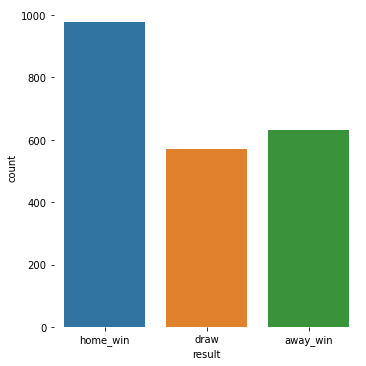

In [38]:
sns.catplot(x="result", data=epl_matches,  kind="count")
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

Clearly home wins make up the biggest portion of the match results. <br>
The number of draws and away wins are close to each other, with slightly more away wins than draws overall.

In [39]:
summary_table = epl_matches.groupby(['season']).agg({'home_win': ['sum'], 'away_win': ['sum'], 'draw': ['sum']})
summary_table.columns = summary_table.columns.droplevel(1)

for i in range(summary_table.shape[0]):
  summary_table.iloc[i] = summary_table.iloc[i]/np.sum(summary_table.iloc[i])

summary_table.columns = ['home_win_%', 'away_win_%', "draw_%"]

summary_table

home_win_%  away_win_%    draw_%
season                                     
2010/2011    0.477612    0.217910  0.304478
2011/2012    0.449591    0.307902  0.242507
2012/2013    0.436842    0.278947  0.284211
2013/2014    0.471698    0.320755  0.207547
2014/2015    0.451429    0.297143  0.251429
2015/2016    0.412234    0.308511  0.279255

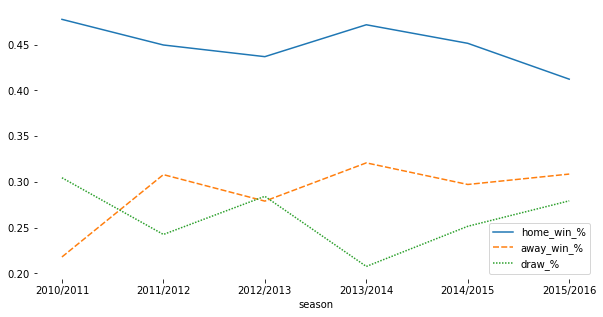

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax = sns.lineplot(data=summary_table)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

The home win % was consistently above the away win and draw % for the seasons in our dataset. <br>

In terms of away wins versus draws, in 4 out of 6 seasons in our data set, the away win % was higher than the draw %.

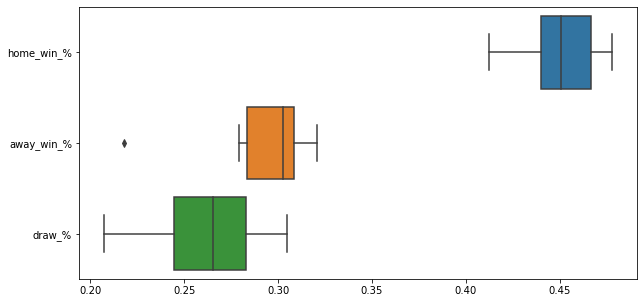

In [41]:
 fig, ax = plt.subplots()
 fig.set_size_inches(10, 5)
 ax = sns.boxplot(data=summary_table, orient="h")
 plt.show()

The above boxplots show once again, the clear difference between % of games ending in a home win and the other results.

#### Home win percentage
In the next two lines, I calculate the % of games ending in a win, as well as the 95% confidence intervall of the % of games ending in a win. <br>

Using the Central Limit Theorem, we can assume that sample means are normally distribute with large samples. This allows us to calculate the confidence interval of our sample mean with the normal distribution. As the sample is sufficiently large with over 2000 games, I use the z score from the standard normal distribution instead of the t distribution for confidence interval calculations.

In [42]:
home_win_perc = np.sum(epl_matches['home_win'])/epl_matches.shape[0]
print('The home win % in our dataset from the 2010/2011 to the 2015/2016 season was', (home_win_perc*100).round(2),'%')

The home win % in our dataset from the 2010/2011 to the 2015/2016 season was 44.93 %


In [43]:
p = home_win_perc # sample proportion
n = epl_matches.shape[0] #sample size

#95% confidence interval and critical probability
confidence_level = 0.95   
alpha = 1-(confidence_level/1)
critical_probability = 1-(alpha/2)  

#z score for 95% confidence interval
z_score = norm.ppf(critical_probability, 0, 1)  

#standard error of a proportion
SE = np.sqrt(p*(1-p)/n)  

#margin in error
ME = z_score*SE  

# confidence interval 99%
lower_boundary = p-ME
upper_boundary = p+ME

print('The 95% confidence interval for our sample home win % of', (home_win_perc*100).round(2), 'is between', (lower_boundary*100).round(2), '% and', (upper_boundary*100).round(2), '%.')

The 95% confidence interval for our sample home win % of 44.93 is between 42.84 % and 47.02 %.


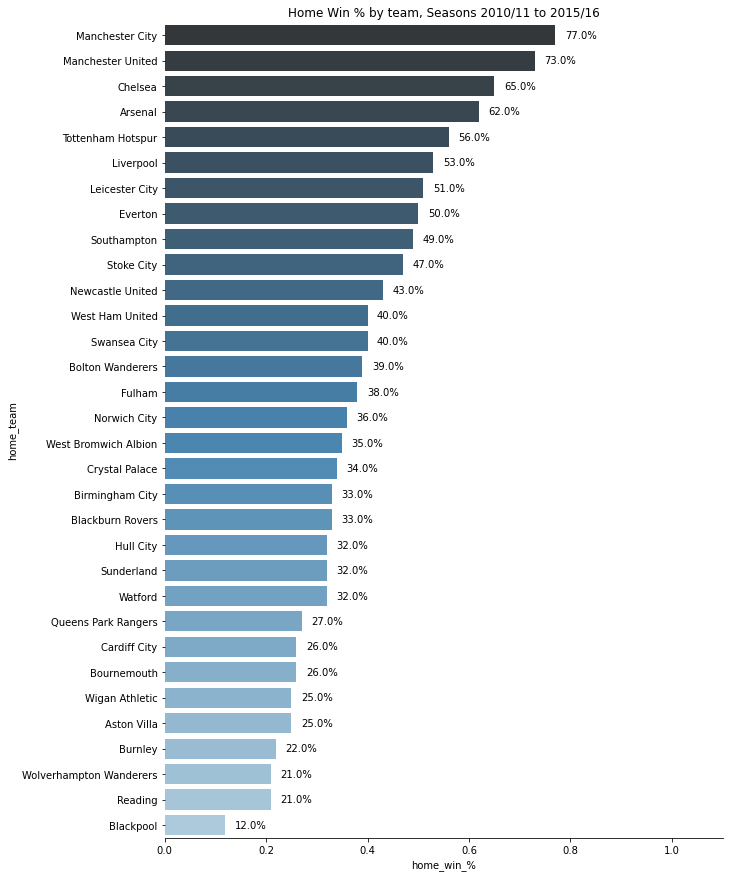

In [44]:
summary_table = epl_matches.groupby(['home_team']).agg({'home_win': ['count', 'sum']})
summary_table.columns = summary_table.columns.droplevel(1)
summary_table.columns = ['matches', 'home_wins']
summary_table['home_win_%'] = round(summary_table['home_wins']/summary_table['matches'], 2)
summary_table = summary_table.sort_values(by=['home_win_%'], ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(10, 15)
ax.set(xlim=(0, 1.1), ylabel="")
ax.set_title('Home Win % by team, Seasons 2010/11 to 2015/16')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax = sns.barplot(y = summary_table.index, x="home_win_%", data=summary_table, palette="Blues_r_d")

for rect in ax.patches:
  # Get X and Y placement of label from rect.
  y_value = rect.get_y() + rect.get_height() / 2
  x_value = rect.get_width()
  
  label = "{0:.1%}".format(x_value)
  
  ax.annotate(label,(x_value+0.05, y_value),ha='center',va='center')

Based on above plot showing the home win % for all teams in our dataset, we see that Manchester City is far above average. This is not surprising considering that they won 2 league titles in the 6 seasons considered, and also finished twice as runners up. <br>

Based on above statistics, Manchester City won on average 8 out of 10 home games. <br>
For Manchester United it was 7 out of 10, followed by Chelsea and Arsenal with approx. 6 out of 10 home wins. <br>

Unfortunately, my team Liverpool was still in a slump during the first half of the 2010s, winning only 5 out of 10 home games on average.

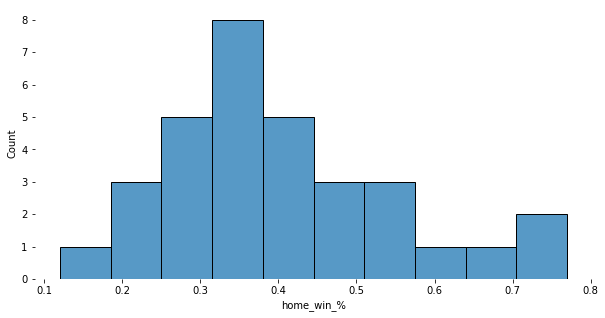

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax = sns.histplot(data = summary_table, x="home_win_%", bins=10)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

Based on the histogram of home win % by team, we can see that most teams are clustered around the mean of approx. 40%, however, some teams show strong home performances over the time frame, with home win % above 60%.

#### Away win percentage

In [46]:
away_win_perc = np.sum(epl_matches['away_win'])/epl_matches.shape[0]
print('The away win % in our dataset from the 2010/2011 to the 2015/2016 season was', (away_win_perc*100).round(2),'%')

The away win % in our dataset from the 2010/2011 to the 2015/2016 season was 28.96 %


In [47]:
p = away_win_perc # sample proportion
n = epl_matches.shape[0] #sample size

#95% confidence interval and critical probability
confidence_level = 0.95   
alpha = 1-(confidence_level/1)
critical_probability = 1-(alpha/2)  

#z score for 95% confidence interval
z_score = norm.ppf(critical_probability, 0, 1)  

#standard error of a proportion
SE = np.sqrt(p*(1-p)/n)  

#margin in error
ME = z_score*SE  

# confidence interval 99%
lower_boundary = p-ME
upper_boundary = p+ME

print('The 95% confidence interval for our sample away win % of', (away_win_perc*100).round(2), 'is between', (lower_boundary*100).round(2), '% and', (upper_boundary*100).round(2), '%.')

The 95% confidence interval for our sample away win % of 28.96 is between 27.05 % and 30.86 %.


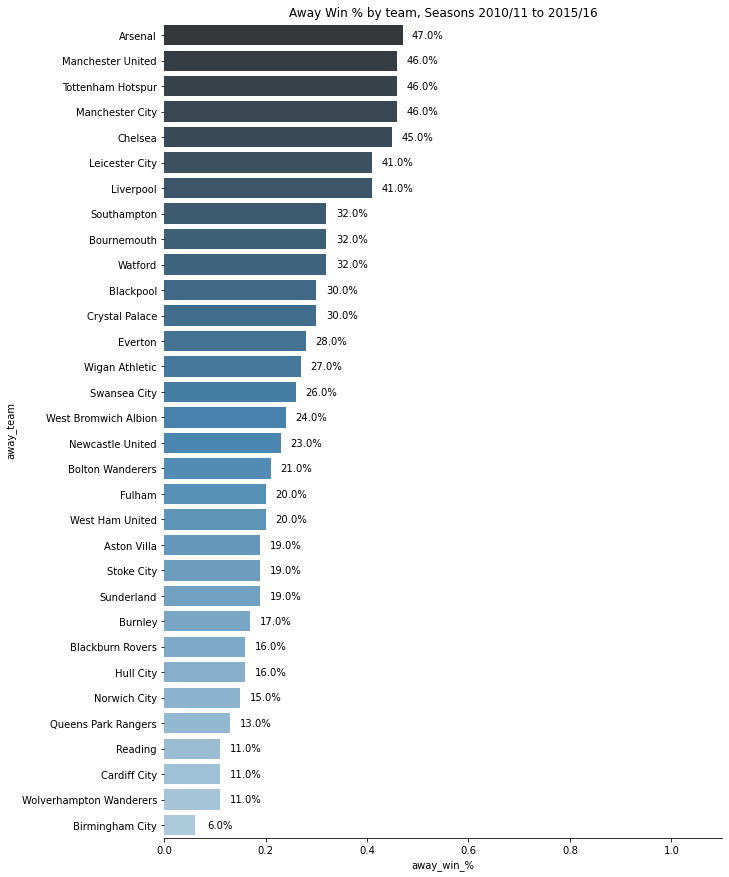

In [48]:
summary_table = epl_matches.groupby(['away_team']).agg({'away_win': ['count', 'sum']})
summary_table.columns = summary_table.columns.droplevel(1)
summary_table.columns = ['matches', 'away_wins']
summary_table['away_win_%'] = round(summary_table['away_wins']/summary_table['matches'], 2)
summary_table = summary_table.sort_values(by=['away_win_%'], ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(10, 15)
ax.set(xlim=(0, 1.1), ylabel="")
ax.set_title('Away Win % by team, Seasons 2010/11 to 2015/16')
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
ax = sns.barplot(y = summary_table.index, x="away_win_%", data=summary_table, palette="Blues_r_d")

for rect in ax.patches:
  # Get X and Y placement of label from rect.
  y_value = rect.get_y() + rect.get_height() / 2
  x_value = rect.get_width()
  
  label = "{0:.1%}".format(x_value)
  
  ax.annotate(label,(x_value+0.05, y_value),ha='center',va='center')

In terms of away win %, we see a big drop off versus home win % for the teams on average. <br>

Interestingly at the top, there is a tight range in the away win %, with a difference of only 2% from the first Arsenal with 47% to the fifth Chelsea with 45%.<br>

This indicates that titles and champions league positions were generally decided based on the home win %, as the away performance was even between the top 5.

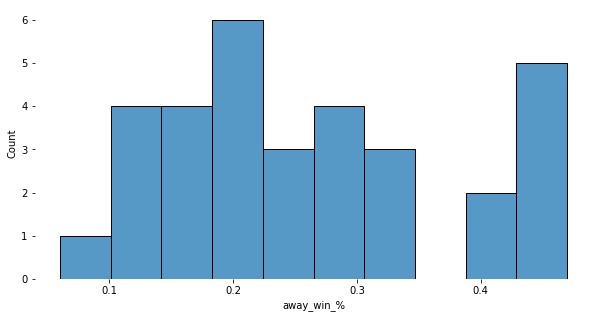

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax = sns.histplot(data = summary_table, x="away_win_%", bins=10, palette="Blues_d")
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

As with home win %, we see a clear outlier with the top teams on the right, with away win % of above 40%.

Most teams are around the 20% mark in terms of away win %.

#### Draw percentage

In [50]:
draw_perc = np.sum(epl_matches['draw'])/epl_matches.shape[0]
print('The % of games ending in a draw in our dataset from the 2010/2011 to the 2015/2016 season was', (draw_perc*100).round(2),'%')

The % of games ending in a draw in our dataset from the 2010/2011 to the 2015/2016 season was 26.11 %


In [51]:
p = draw_perc # sample proportion
n = epl_matches.shape[0] #sample size

#95% confidence interval and critical probability
confidence_level = 0.95   
alpha = 1-(confidence_level/1)
critical_probability = 1-(alpha/2)  

#z score for 95% confidence interval
z_score = norm.ppf(critical_probability, 0, 1)  

#standard error of a proportion
SE = np.sqrt(p*(1-p)/n)  

#margin in error
ME = z_score*SE  

# confidence interval 99%
lower_boundary = p-ME
upper_boundary = p+ME

print('The 95% confidence interval for our sample of', (draw_perc*100).round(2), '% of games ending in a draw of is between', (lower_boundary*100).round(2), '% and', (upper_boundary*100).round(2), '%.')

The 95% confidence interval for our sample of 26.11 % of games ending in a draw of is between 24.27 % and 27.96 %.


### Goals Scored

Goals scored will unfortunately not help us in predicting the outcome of the match, as this information will not be available at time of match prediction before the game. <br>

For reference and out of interest I have added below plots, but will continue with comments from the player section.

#### Home and away goals scored

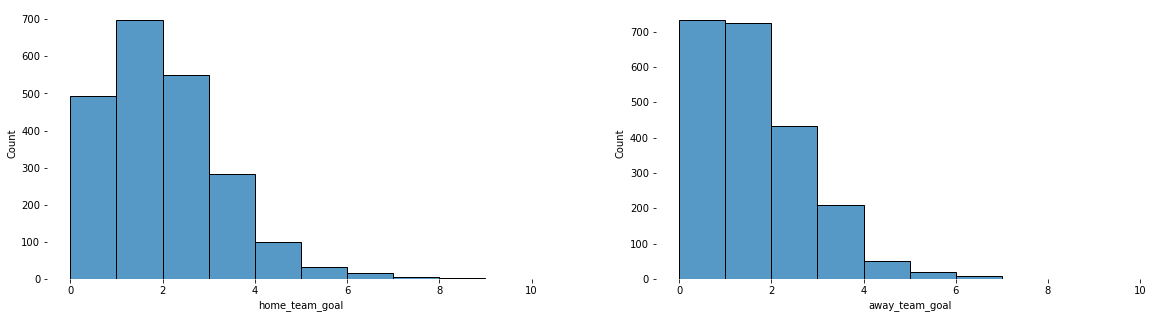

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 5)
sns.histplot(data = epl_matches, x="home_team_goal", bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ax=ax1)
sns.histplot(data = epl_matches, x="away_team_goal", bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ax=ax2)
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

In [53]:
epl_matches[['home_team_goal', 'away_team_goal']].describe()

home_team_goal  away_team_goal
count     2179.000000     2179.000000
mean         1.541074        1.176687
std          1.296508        1.150114
min          0.000000        0.000000
25%          1.000000        0.000000
50%          1.000000        1.000000
75%          2.000000        2.000000
max          8.000000        6.000000

In [54]:
summary_table = epl_matches.groupby(['season', 'league_name']).agg({'home_team_goal': ['count', 'sum', 'mean'], 'away_team_goal': ['sum', 'mean']})
summary_table.columns = summary_table.columns.droplevel(1)
summary_table.columns = ['matches', 'total_home_team_goals', 'mean_home_team_goals', 'total_away_team_goals', 'mean_away_team_goals']
summary_table

matches  total_home_team_goals  \
season    league_name                                              
2010/2011 England Premier League      335                    539   
2011/2012 England Premier League      367                    582   
2012/2013 England Premier League      380                    592   
2013/2014 England Premier League      371                    578   
2014/2015 England Premier League      350                    506   
2015/2016 England Premier League      376                    561   

                                  mean_home_team_goals  total_away_team_goals  \
season    league_name                                                           
2010/2011 England Premier League              1.608955                    375   
2011/2012 England Premier League              1.585831                    450   
2012/2013 England Premier League              1.557895                    471   
2013/2014 England Premier League              1.557951                    439   
2014/2015 England Premier League              1.445714                    372   
2015/2016 England Premier League              1.492021                    457   

                                  mean_away_team_goals  
season    league_name                                   
2010/2011 England Premier League              1.119403  
2011/2012 England Premier League              1.226158  
2012/2013 England Premier League              1.239474  
2013/2014 England Premier League              1.183288  
2014/2015 England Premier League              1.062857  
2015/2016 England Premier League              1.215426

### Players

In this section I will analyse the relationship between the player data and the match outcome. <br>

As a proxy for the match outcome, I will use the home win variable, which is one hot encoded to 1, if the home team won the match, and 0 if the match ended in a draw or the away team won.

For all correlation coefficient calculations, I use the pandas [pandas.DataFrame.corr](
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) function. <br>

This returns by default the Pearson correlation for two continuous variables, and the Point-biserial correlation for a continuous with a one hot encoded variable, which is [mathematically equivalent](https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient) to the Pearson correlation.

#### Home team starting elevel overall player ratings

<AxesSubplot:>

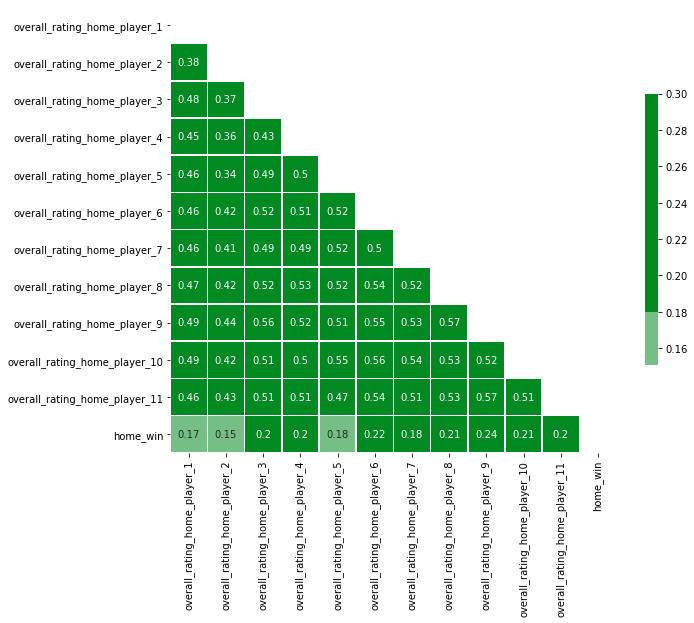

In [55]:
home_players = ['home_player_1',	'home_player_2',	'home_player_3',	'home_player_4',	'home_player_5',	'home_player_6',
                   'home_player_7',	'home_player_8',	'home_player_9',	'home_player_10',	'home_player_11']
z = 'overall_rating_'
column_list = []
for player in home_players:
  column_name = z+player
  column_list.append(column_name)
column_list
column_list.append('home_win')

#get correlation matrix
corr = epl_matches[column_list].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Based on the correlation coefficients of the overall eleven home player ratings with the home win variable, referring to the last row in the correlation matrix, we see that all eleven are positive, indicating the possibility that higher home player ratings lead to a higher chance of a home win. <br>

This indicates that the player ratings could possibly be useful in predicting the chance of a home win. <br>

Interestingly the correlation matrix also shows a high correlation of overall home player ratings with other home player ratings. This indicates that in general, players with higher ratings play in the same team, as do players with lower ratings play in the same team.

#### Away team starting elevel overall player ratings

<AxesSubplot:>

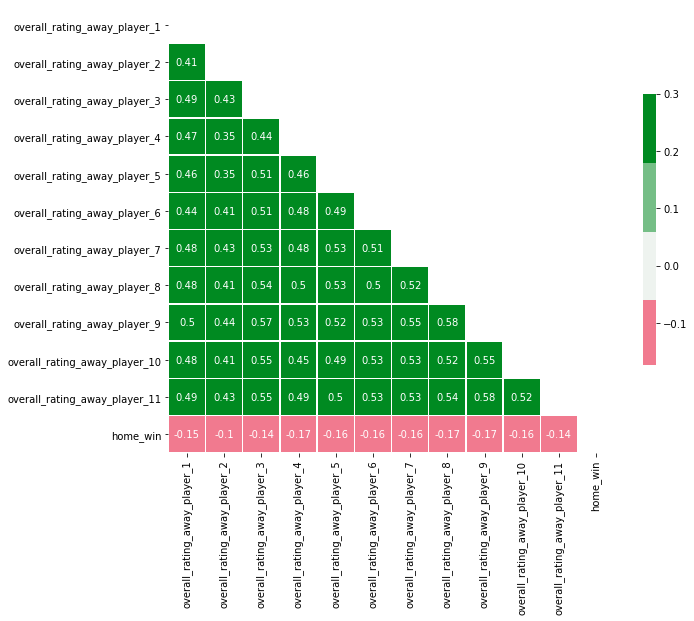

In [56]:
away_players = ['away_player_1',	'away_player_2',	'away_player_3',	'away_player_4',	'away_player_5',	'away_player_6',
                   'away_player_7',	'away_player_8',	'away_player_9',	'away_player_10',	'away_player_11']
z = 'overall_rating_'
column_list = []
for player in away_players:
  column_name = z+player
  column_list.append(column_name)
column_list
column_list.append('home_win')

corr = epl_matches[column_list].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Based on the correlation coefficients of the overall eleven away player ratings with the home win variable, referring to the last row in the correlation matrix, we see that all eleven are negative, indicating the possibility that higher away player ratings lead to a lower chance of a home win. <br>

This indicates that the player ratings could possibly be useful in predicting the chance of a home win. <br>

Interestingly the correlation matrix also shows a high correlation of overall away player ratings with other away player ratings. This indicates that in general, players with higher ratings play in the same team, as do players with lower ratings play in the same team.

#### Home team starting eleven detailed player attributes
The following code shows separate correlation matrices of the detailed player attributes and the home win variable, for all eleven home players. I will comment on the overall conclusion after the last correlation matrix.

<AxesSubplot:>

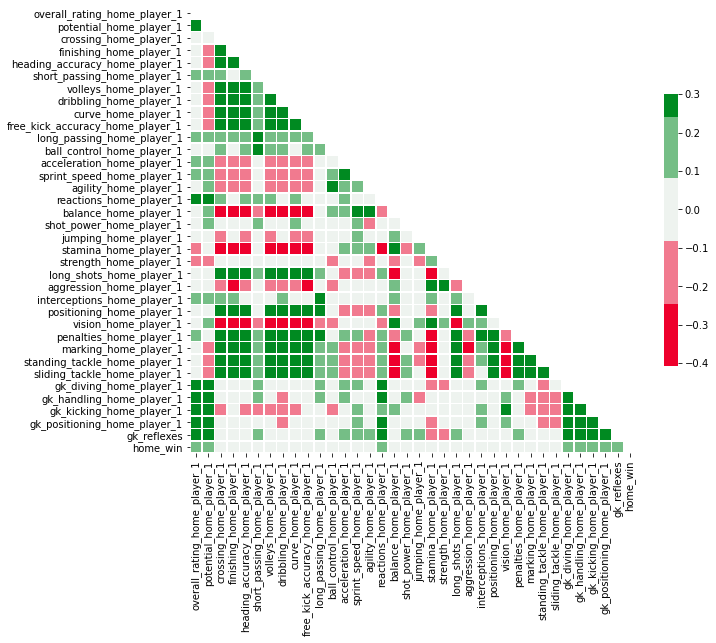

In [57]:
home_player_1_columns = list(epl_matches.columns[50:88])
home_player_1_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_1_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

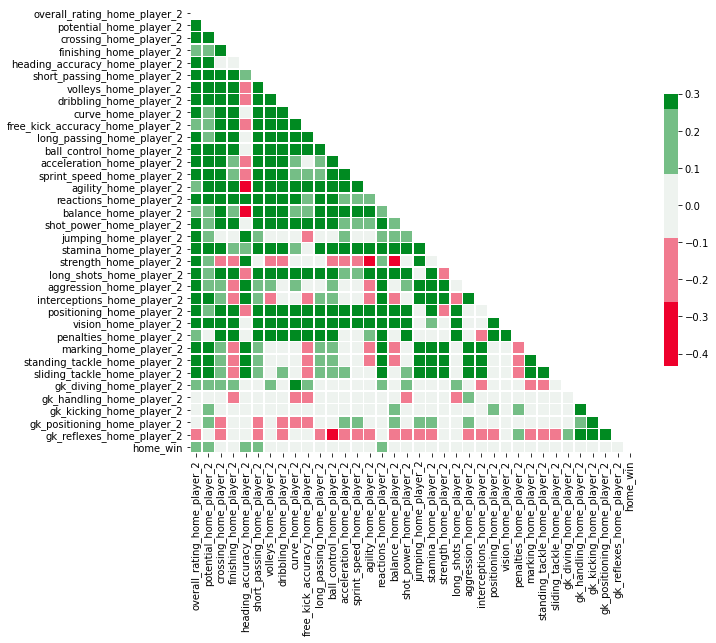

In [58]:
home_player_2_columns = list(epl_matches.columns[88:126])
home_player_2_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_2_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

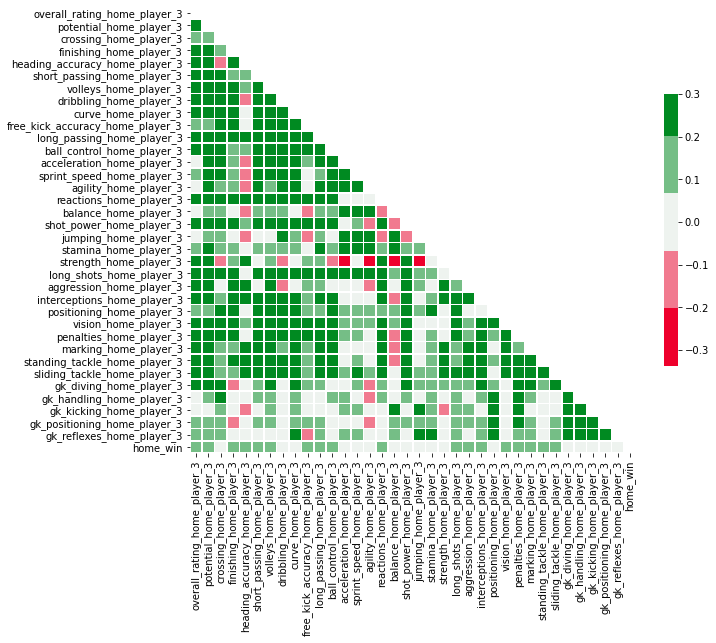

In [59]:
home_player_3_columns = list(epl_matches.columns[126:164])
home_player_3_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_3_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

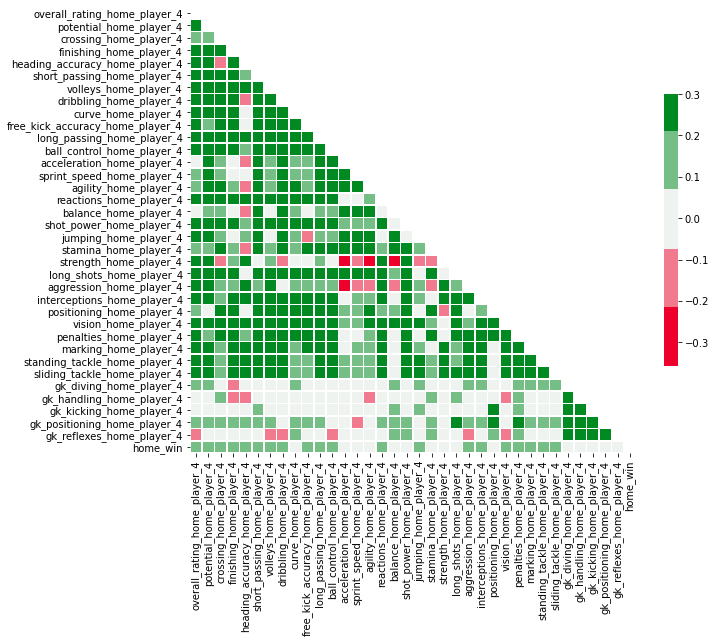

In [60]:
home_player_4_columns = list(epl_matches.columns[164:202])
home_player_4_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_4_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

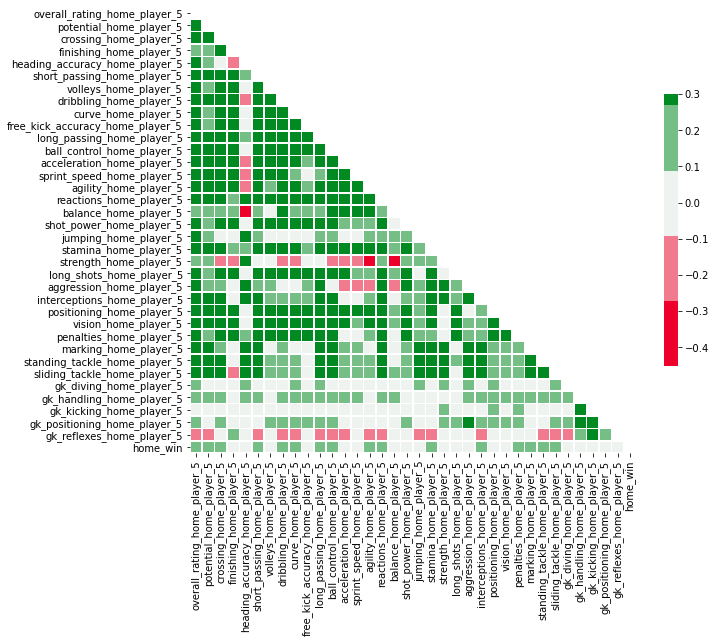

In [61]:
home_player_5_columns = list(epl_matches.columns[202:240])
home_player_5_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_5_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

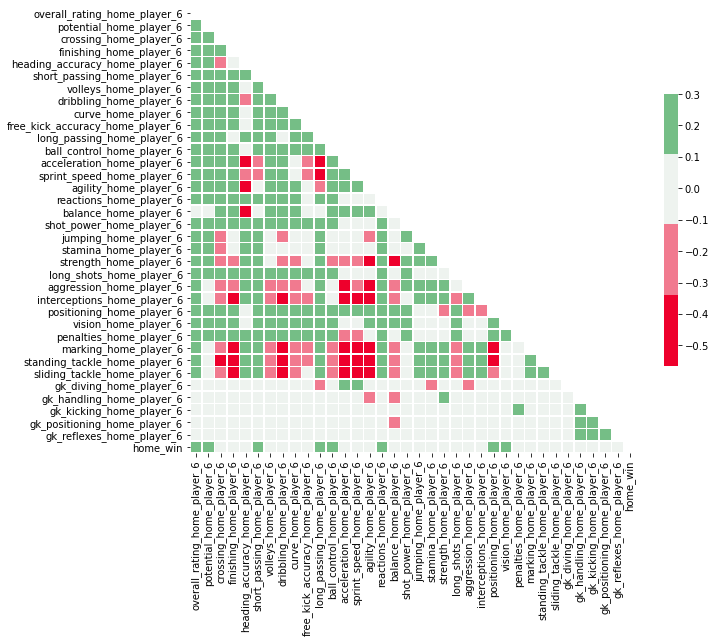

In [62]:
home_player_6_columns = list(epl_matches.columns[240:278])
home_player_6_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_6_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

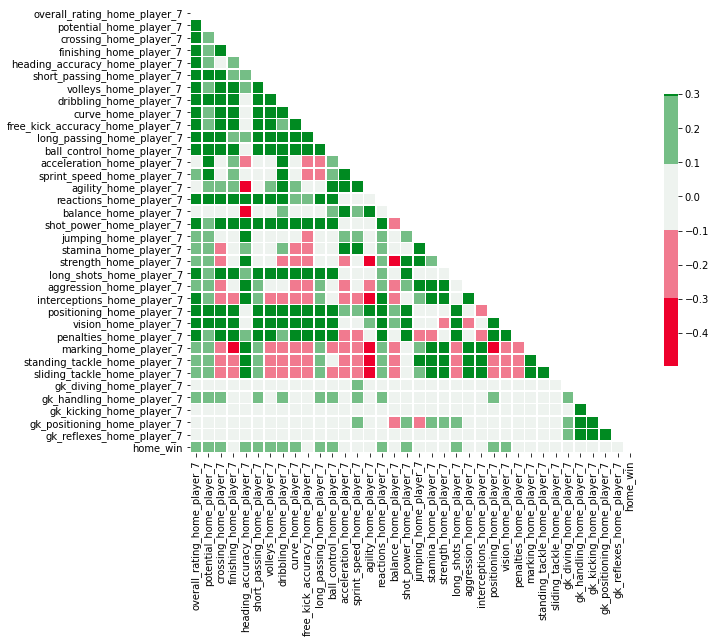

In [63]:
home_player_7_columns = list(epl_matches.columns[278:316])
home_player_7_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_7_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

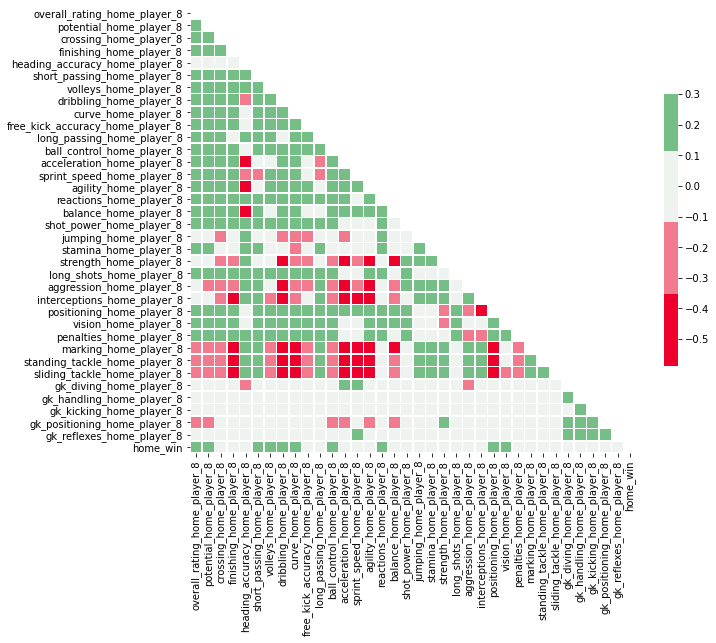

In [64]:
home_player_8_columns = list(epl_matches.columns[316:354])
home_player_8_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_8_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

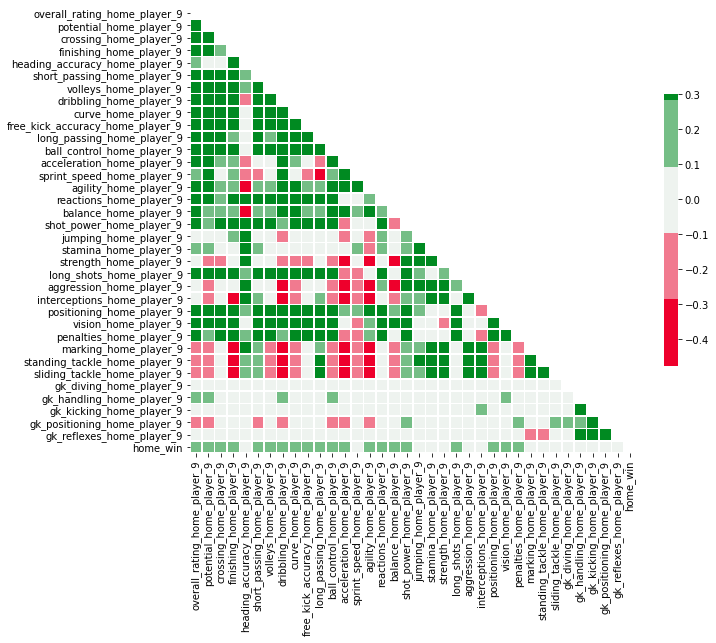

In [65]:
home_player_9_columns = list(epl_matches.columns[354:392])
home_player_9_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_9_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

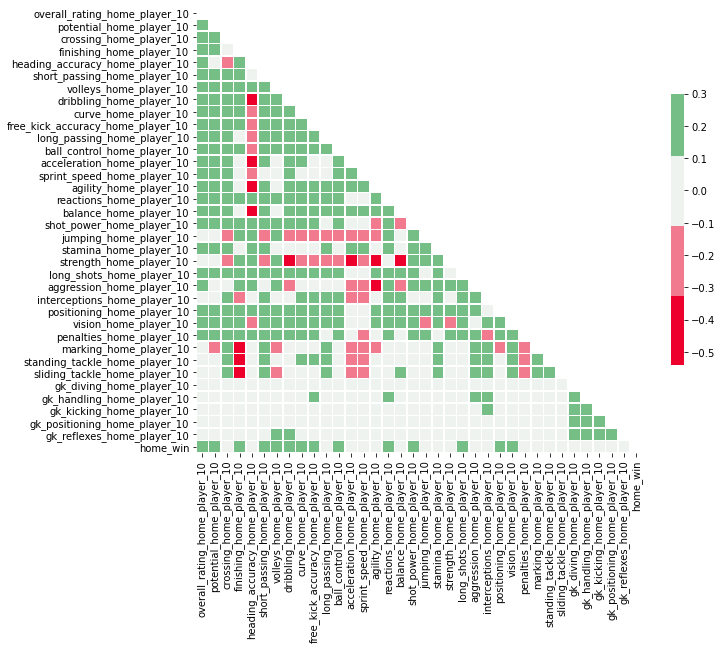

In [66]:
home_player_10_columns = list(epl_matches.columns[392:430])
home_player_10_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_10_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

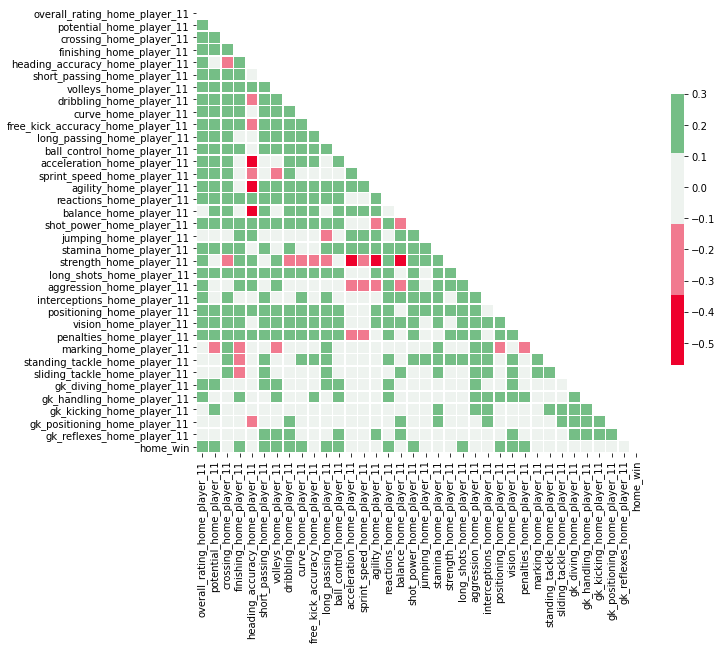

In [67]:
home_player_11_columns = list(epl_matches.columns[430:468])
home_player_11_columns.append('home_win')

#get correlation matrix
corr = epl_matches[home_player_11_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

Based on the correlation coefficients for all eleven home player attributes with the home win variable, referring to the last row in the correlation matrix, we see that the correlation coefficients are either slightly positive or close to 0. Interestingly, depending on the position of the player, different attributes seem to correlate higher.

Player 1 is clearly the goalkeeper, as here goalkeeping attributes correlate higher with the home win variable, indicating that a stronger goalkeeper could lead to more home wins. <br>

For player 3 and 4, tackling and marking attributes correlate higher with the home win variable, indicating that these players are defenders, and stronger defensive attributes could lead to more home wins.

For players 6, 7, 8, 9, a mixture of vision, passing and dribbling attributes correlate higher with home wins, indicating that these are midfield players.

Players 9, 10, 11 seems to be the main goal scorers, as here the finishing ability correlates higher with the home win variable.

#### Away team starting eleven detailed player attributes
The following code shows separate correlation matrices of the detailed player attributes and the home win variable, for all eleven away players. As with the home players, I will comment on the overall conclusion after the last correlation matrix.

<AxesSubplot:>

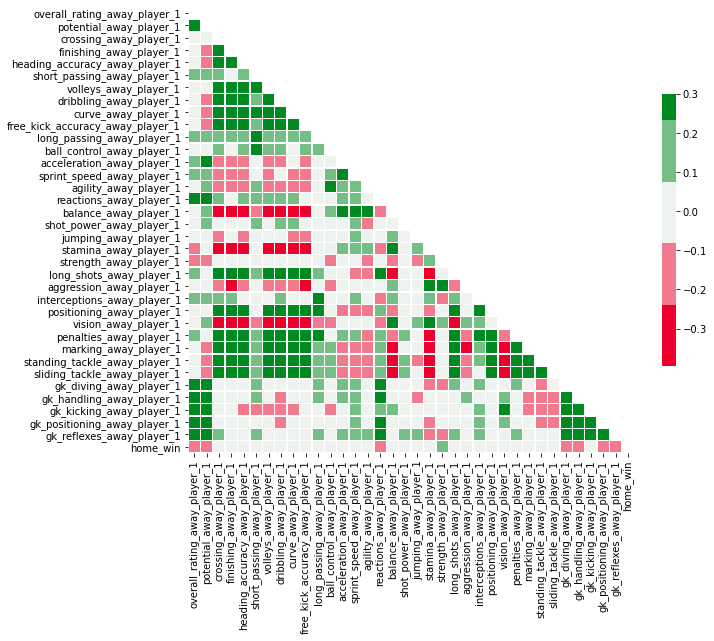

In [68]:
away_player_1_columns = list(epl_matches.columns[468:506])
away_player_1_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_1_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

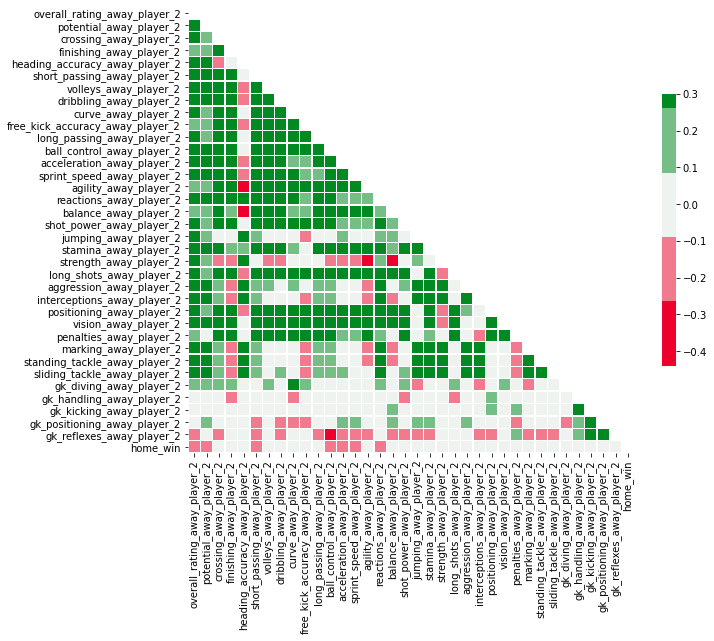

In [69]:
away_player_2_columns = list(epl_matches.columns[506:544])
away_player_2_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_2_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

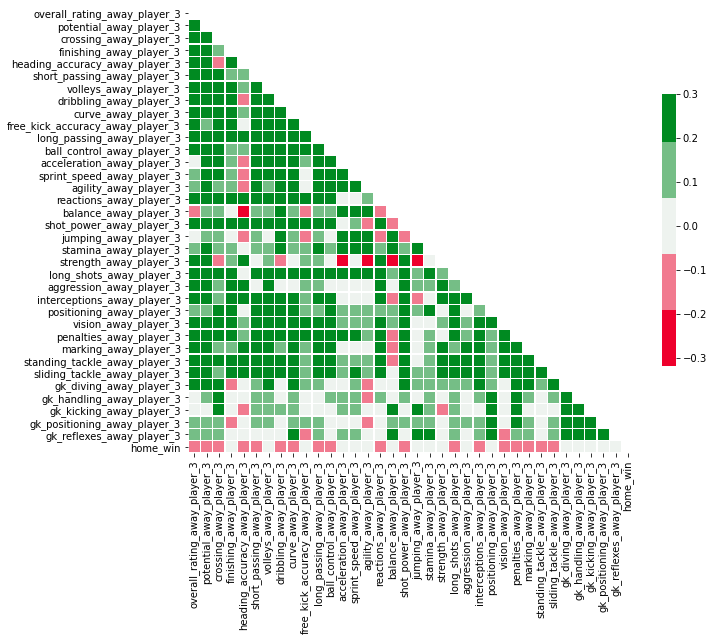

In [70]:
away_player_3_columns = list(epl_matches.columns[544:582])
away_player_3_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_3_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

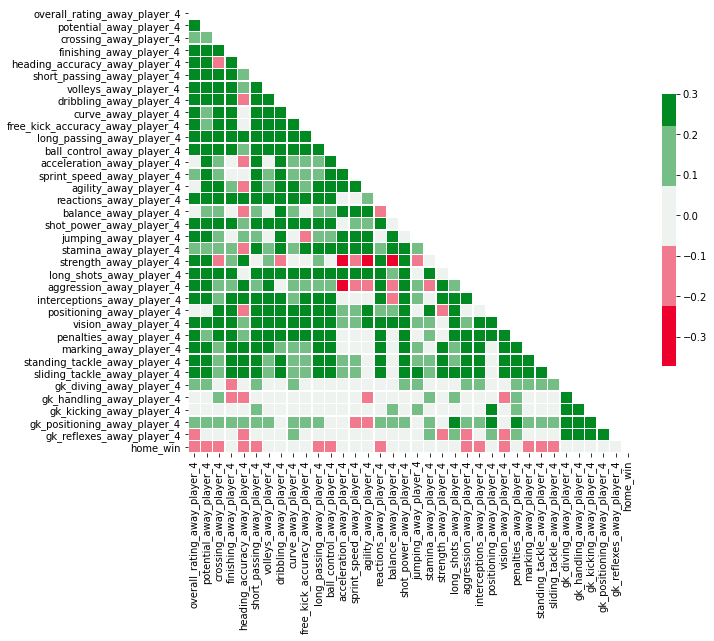

In [71]:
away_player_4_columns = list(epl_matches.columns[582:620])
away_player_4_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_4_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

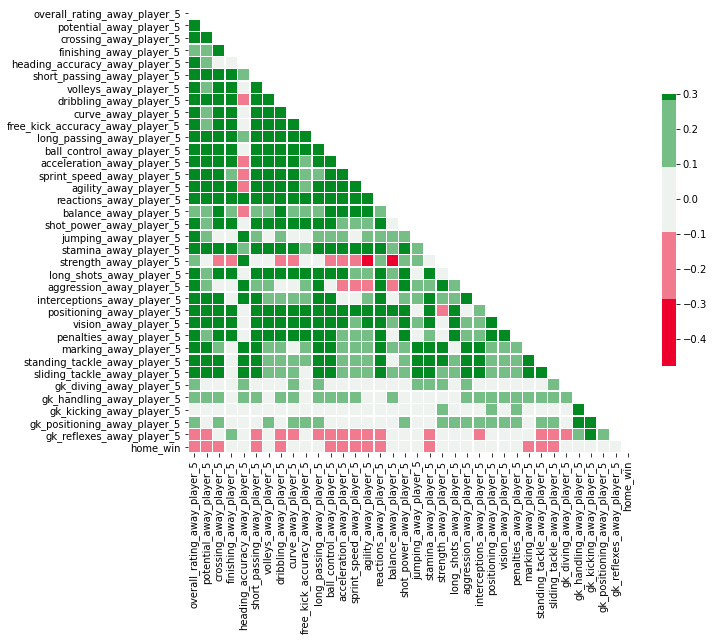

In [72]:
away_player_5_columns = list(epl_matches.columns[620:658])
away_player_5_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_5_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

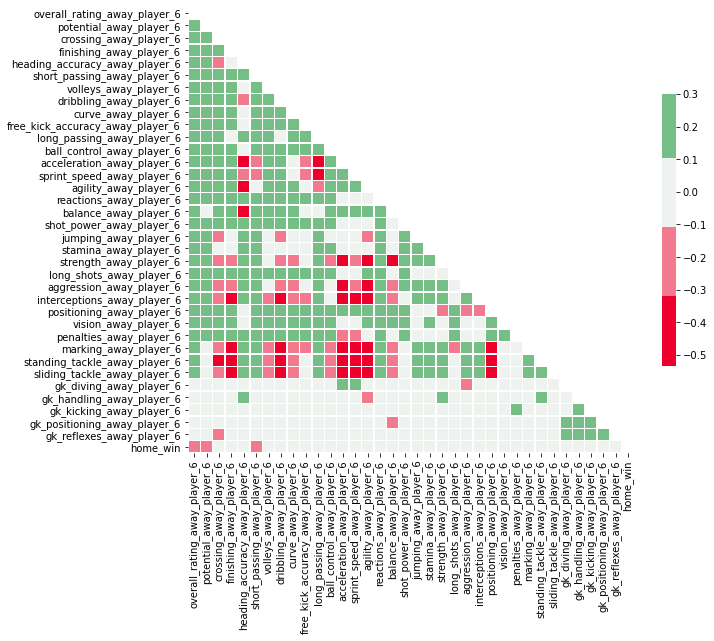

In [73]:
away_player_6_columns = list(epl_matches.columns[658:696])
away_player_6_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_6_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

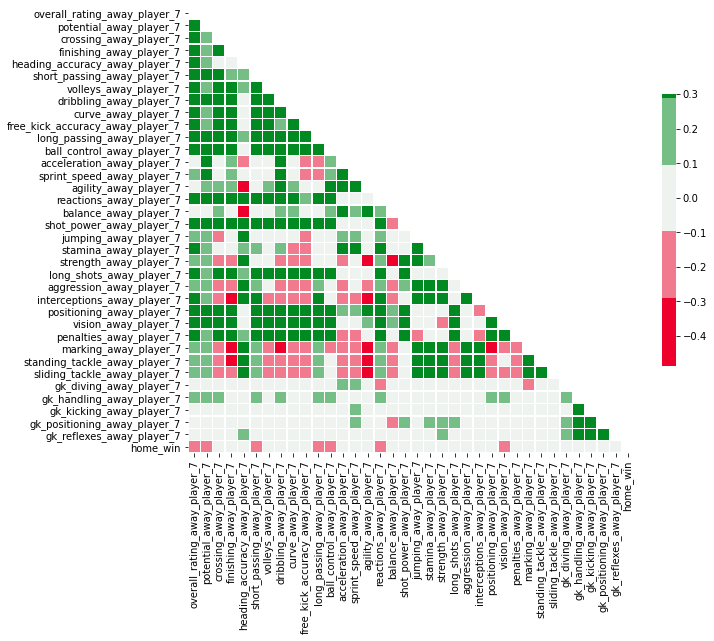

In [74]:
away_player_7_columns = list(epl_matches.columns[696:734])
away_player_7_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_7_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

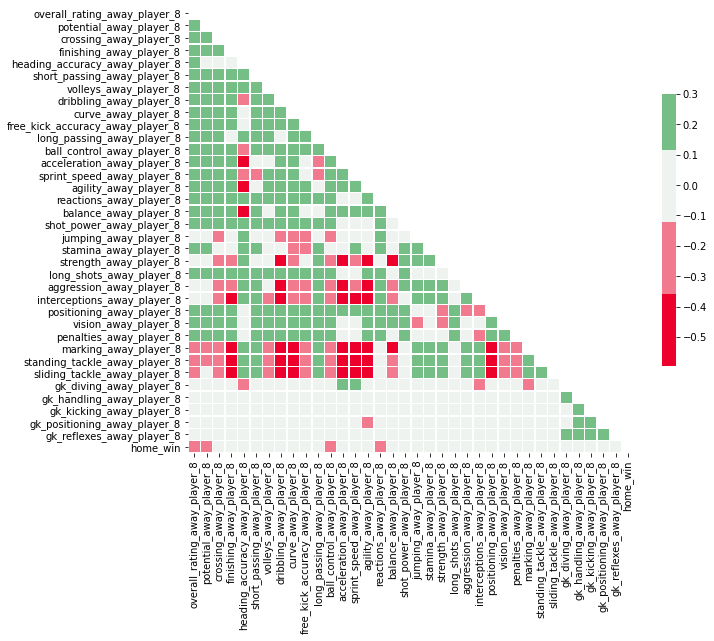

In [75]:
away_player_8_columns = list(epl_matches.columns[734:772])
away_player_8_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_8_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

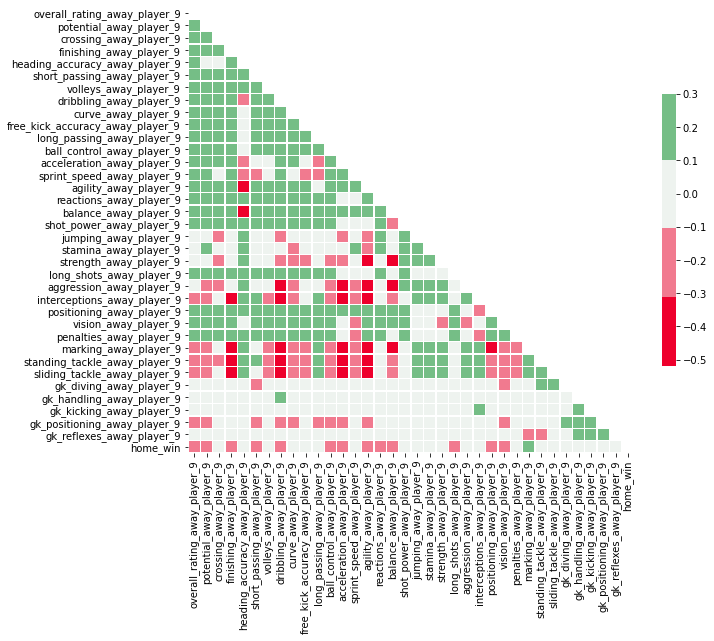

In [76]:
away_player_9_columns = list(epl_matches.columns[772:810])
away_player_9_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_9_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

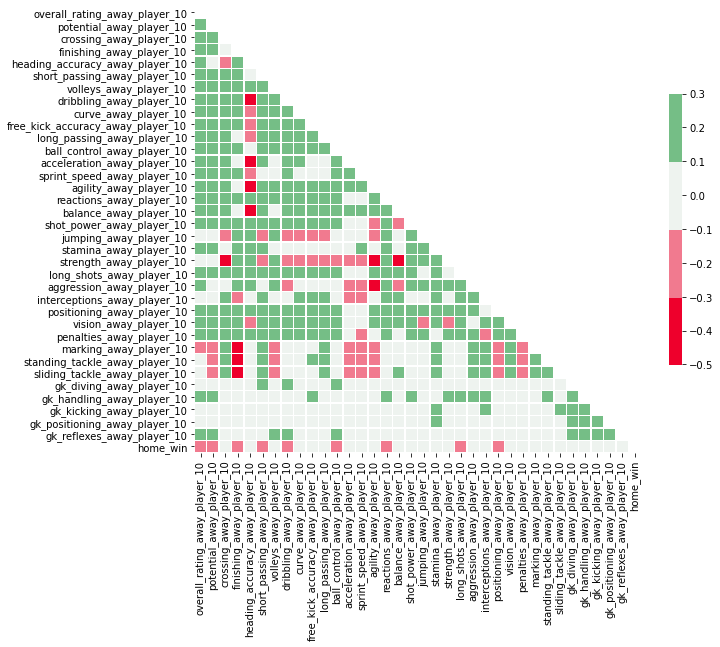

In [77]:
away_player_10_columns = list(epl_matches.columns[810:848])
away_player_10_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_10_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

<AxesSubplot:>

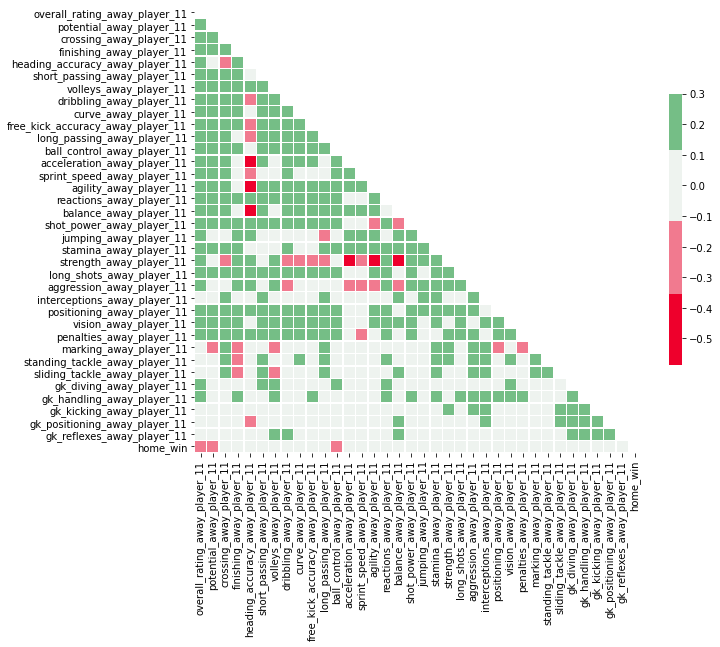

In [78]:
away_player_11_columns = list(epl_matches.columns[848:886])
away_player_11_columns.append('home_win')

#get correlation matrix
corr = epl_matches[away_player_11_columns].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

As we would expect, we see the opposite picture for the away player attribute correlations with the home win variable.

Based on the correlation coefficients for all eleven away player attributes with the home win variable, referring to the last row in the correlation matrix, we see that the correlation coefficients are either slightly negative or close to 0. As with the home player attributes, depending on the position of the player, different attributes seem to correlate more negative.

Player 1 is clearly the goalkeeper, as here goalkeeping attributes correlate more negative with the home win variable, indicating that a stronger away goalkeeper could lead to less home wins.<br>

For player 3 and 4, tackling and marking attributes correlate more negative with the home win variable, indicating that these players are defenders, and stronger defensive attributes for away players could lead to less home wins.

For players 6, 7, 8, 9, a mixture of vision, passing and dribbling attributes correlate more negative with home wins, indicating that these are midfield players.

Players 9, 10, seem to be the main goal scorers, as here the finishing ability correlates more negative with the home win variable.

### Teams

In the next section I look at the correlation of team attributes with the home win variable. As noted during the data processing part, the very infrequent updates of the team attributes could make them less useful as predictive features. <br>

Also, to note is that unlike for players, there is no overall rating variable, but only team attributes.

#### Home team attributes

<AxesSubplot:>

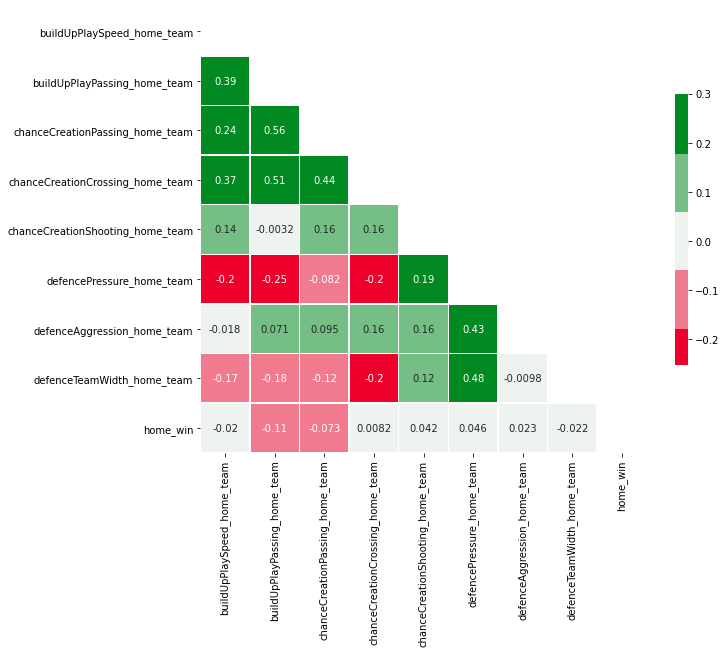

In [79]:
home_team_attributes = list(epl_matches.columns[10:30])
home_team_attributes.append('home_win')
epl_matches[home_team_attributes].corr()

corr = epl_matches[home_team_attributes].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Unfortunately, the home team features seem to not correlate at all with the home win variable. There are even some small negative correlations, indicating stronger home team attributes could lead to fewer home wins.

As noted, this contradiction could be due to the issue that the data was not updated very frequently and is therefore not useful for prediction compared to player data, which was updated very frequently.

#### Away team attributes

<AxesSubplot:>

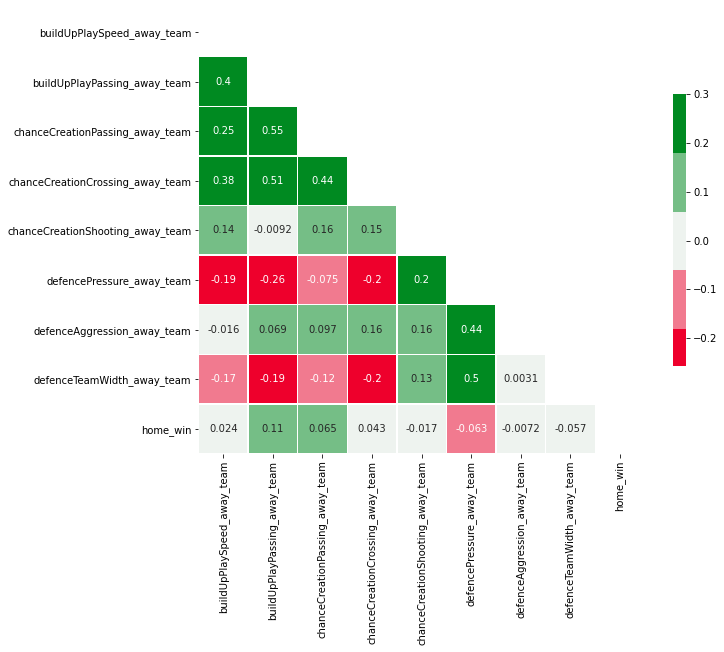

In [80]:
home_team_attributes = list(epl_matches.columns[30:50])
home_team_attributes.append('home_win')
epl_matches[home_team_attributes].corr()

corr = epl_matches[home_team_attributes].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))         # Generate a mask for the upper triangle
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
cmap = sns.diverging_palette(10, 130, s=100, n=5)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

Unfortunately, the away team features show the same situation as the home team features.
The away team features seem to not correlate at all with the home win variable. There are even some small positive correlations, indicating stronger away team attributes could lead to more home wins.

As noted, this contradiction could be due to the issue that the data was not updated very frequently, and is therefore not useful for prediction compared to player data, which was updated very frequently.

### Conclusion from Exploratory Data Analysis

Based on the analysis of player and team data, the player data clearly shows the correlations one would expect.
Stronger home team players correlate positively with the home win variable, whereas stronger away team players correlate negatively with the home win variable. Depending on the position of the players, different variables correlate stronger with the home win variable. <br>
Based on above I conclude that we should keep the player data as the correlations indicate they could be useful for predicting the match result.
Some player attributes may be less useful than others, based on the position of the player. To reduce the feature dimension later, I will therefore use Principal Component Analysis, to reduce the feature space but keeping most of the information in the data. <br>

Unfortunately, as feared due to the very infrequent updates, the team attribute data seems to not be especially useful for predicting the match results. Considering the non-existing correlations with the home win variable and our already high feature dimension space, I will remove all team attribute variables from the data set before training machine learning algorithms.

The following code drops all team attribute variables. <br>

In addition, I will also drop all result columns except the home win column. This will be used as a proxy to try to predict the result, in this case a home win.

In [81]:
#remove team colums
team_attribute_columns = list(epl_matches.columns[10:50])
data = epl_matches.drop(labels = team_attribute_columns, axis=1)
data.head(5)

season  match_day match_date country_name             league_name  \
0  2010/2011          1 2010-08-14      England  England Premier League   
1  2010/2011          1 2010-08-14      England  England Premier League   
2  2010/2011          1 2010-08-14      England  England Premier League   
3  2010/2011          1 2010-08-14      England  England Premier League   
4  2010/2011          1 2010-08-14      England  England Premier League   

                 home_team             away_team  home_team_goal  \
0              Aston Villa       West Ham United               3   
1         Bolton Wanderers                Fulham               0   
2                  Chelsea  West Bromwich Albion               6   
3  Wolverhampton Wanderers            Stoke City               2   
4           Wigan Athletic             Blackpool               0   

   away_team_goal  match_api_id  overall_rating_home_player_1  \
0               0        839796                          82.0   
1               0        839799                          80.0   
2               0        839800                          85.0   
3               1        839805                          73.0   
4               4        840184                          77.0   

   potential_home_player_1 preferred_foot_home_player_1  \
0                     84.0                        right   
1                     81.0                        right   
2                     90.0                         left   
3                     71.0                        right   
4                     83.0                        right   

  attacking_work_rate_home_player_1 defensive_work_rate_home_player_1  \
0                            medium                            medium   
1                            medium                            medium   
2                            medium                            medium   
3                            medium                            medium   
4                            medium                            medium   

   crossing_home_player_1  finishing_home_player_1  \
0                    23.0                     23.0   
1                    22.0                     22.0   
2                    20.0                     20.0   
3                    21.0                     21.0   
4                    23.0                     23.0   

   heading_accuracy_home_player_1  short_passing_home_player_1  \
0                            23.0                         24.0   
1                            22.0                         25.0   
2                            20.0                         25.0   
3                             9.0                         29.0   
4                            23.0                         26.0   

   volleys_home_player_1  dribbling_home_player_1  curve_home_player_1  \
0                   10.0                     23.0                 18.0   
1                    9.0                     22.0                 12.0   
2                   17.0                     20.0                  9.0   
3                   20.0                      7.0                 19.0   
4                   12.0                     23.0                 12.0   

   free_kick_accuracy_home_player_1  long_passing_home_player_1  \
0                              19.0                        82.0   
1                              15.0                        78.0   
2                              19.0                        79.0   
3                              17.0                        74.0   
4                              10.0                        80.0   

   ball_control_home_player_1  acceleration_home_player_1  \
0                        22.0                        32.0   
1                        23.0                        50.0   
2                        24.0                        39.0   
3                        22.0                        50.0   
4                        22.0                        50.0   

   sprint_speed_home_pla

In [82]:
#remove remaining id columns
columns_to_drop = list(data.columns[0:10])
data = data.drop(labels = columns_to_drop, axis=1)
data.head(5)

overall_rating_home_player_1  potential_home_player_1  \
0                          82.0                     84.0   
1                          80.0                     81.0   
2                          85.0                     90.0   
3                          73.0                     71.0   
4                          77.0                     83.0   

  preferred_foot_home_player_1 attacking_work_rate_home_player_1  \
0                        right                            medium   
1                        right                            medium   
2                         left                            medium   
3                        right                            medium   
4                        right                            medium   

  defensive_work_rate_home_player_1  crossing_home_player_1  \
0                            medium                    23.0   
1                            medium                    22.0   
2                            medium                    20.0   
3                            medium                    21.0   
4                            medium                    23.0   

   finishing_home_player_1  heading_accuracy_home_player_1  \
0                     23.0                            23.0   
1                     22.0                            22.0   
2                     20.0                            20.0   
3                     21.0                             9.0   
4                     23.0                            23.0   

   short_passing_home_player_1  volleys_home_player_1  \
0                         24.0                   10.0   
1                         25.0                    9.0   
2                         25.0                   17.0   
3                         29.0                   20.0   
4                         26.0                   12.0   

   dribbling_home_player_1  curve_home_player_1  \
0                     23.0                 18.0   
1                     22.0                 12.0   
2                     20.0                  9.0   
3                      7.0                 19.0   
4                     23.0                 12.0   

   free_kick_accuracy_home_player_1  long_passing_home_player_1  \
0                              19.0                        82.0   
1                              15.0                        78.0   
2                              19.0                        79.0   
3                              17.0                        74.0   
4                              10.0                        80.0   

   ball_control_home_player_1  acceleration_home_player_1  \
0                        22.0                        32.0   
1                        23.0                        50.0   
2                        24.0                        39.0   
3                        22.0                        50.0   
4                        22.0                        50.0   

   sprint_speed_home_player_1  agility_home_player_1  reactions_home_player_1  \
0                        53.0                   45.0                     69.0   
1                        52.0                   43.0                     44.0   
2                        45.0                   49.0                     77.0   
3                        53.0                   49.0                     64.0   
4                        51.0                   54.0                     67.0   

   balance_home_player_1  shot_power_home_player_1  jumping_home_player_1  \
0                   58.0                      22.0                   50.0   
1                   54.0                      26.0                   67.0   
2                   60.0                      21.0                   79.0   
3                   48.0                      25.0                   54.0   
4                   49.0                      22.0                   78.0   

   stamina_home_player_1  strength_home_player_1  long_shots_home_player_1  \
0                   65.0         

In [83]:
#drop labels other than home win
columns_to_drop = data.columns[-3:]
data = data.drop(labels = columns_to_drop, axis=1)
data.head(5)

overall_rating_home_player_1  potential_home_player_1  \
0                          82.0                     84.0   
1                          80.0                     81.0   
2                          85.0                     90.0   
3                          73.0                     71.0   
4                          77.0                     83.0   

  preferred_foot_home_player_1 attacking_work_rate_home_player_1  \
0                        right                            medium   
1                        right                            medium   
2                         left                            medium   
3                        right                            medium   
4                        right                            medium   

  defensive_work_rate_home_player_1  crossing_home_player_1  \
0                            medium                    23.0   
1                            medium                    22.0   
2                            medium                    20.0   
3                            medium                    21.0   
4                            medium                    23.0   

   finishing_home_player_1  heading_accuracy_home_player_1  \
0                     23.0                            23.0   
1                     22.0                            22.0   
2                     20.0                            20.0   
3                     21.0                             9.0   
4                     23.0                            23.0   

   short_passing_home_player_1  volleys_home_player_1  \
0                         24.0                   10.0   
1                         25.0                    9.0   
2                         25.0                   17.0   
3                         29.0                   20.0   
4                         26.0                   12.0   

   dribbling_home_player_1  curve_home_player_1  \
0                     23.0                 18.0   
1                     22.0                 12.0   
2                     20.0                  9.0   
3                      7.0                 19.0   
4                     23.0                 12.0   

   free_kick_accuracy_home_player_1  long_passing_home_player_1  \
0                              19.0                        82.0   
1                              15.0                        78.0   
2                              19.0                        79.0   
3                              17.0                        74.0   
4                              10.0                        80.0   

   ball_control_home_player_1  acceleration_home_player_1  \
0                        22.0                        32.0   
1                        23.0                        50.0   
2                        24.0                        39.0   
3                        22.0                        50.0   
4                        22.0                        50.0   

   sprint_speed_home_player_1  agility_home_player_1  reactions_home_player_1  \
0                        53.0                   45.0                     69.0   
1                        52.0                   43.0                     44.0   
2                        45.0                   49.0                     77.0   
3                        53.0                   49.0                     64.0   
4                        51.0                   54.0                     67.0   

   balance_home_player_1  shot_power_home_player_1  jumping_home_player_1  \
0                   58.0                      22.0                   50.0   
1                   54.0                      26.0                   67.0   
2                   60.0                      21.0                   79.0   
3                   48.0                      25.0                   54.0   
4                   49.0                      22.0                   78.0   

   stamina_home_player_1  strength_home_player_1  long_shots_home_player_1  \
0                   65.0         

In [84]:
#check final data shape
data.shape

(2179, 837)

In [85]:
#check final data for missing values
data.isna().sum().sum()

0

## Part 2.2 Machine Learning
In the final part of this notebook, I will train several classifiers to predict the home win variable based on player data of the 11 starting players in both the home and away teams. The home win outcome variable is one hot encoded, with 1 if the home team won and 0 in case the game ended in a draw or the away team won.

In the next few lines of code, the data is split into features and labels, and after split into training and test data. The test data will be put aside and only used at the very end, to get an out of sample error estimation for the final selected model.

All model training and hyper parameter tuning is done on the training set with cross validation.

In [86]:
# split data into independant variables X (player attributes) and dependant variable y (home win)
X_data = data.drop(columns=['home_win'])
y_data = data['home_win']

In [87]:
#split data into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, shuffle=True, test_size=0.3, random_state=42, stratify = y_data)

In [88]:
# overview X train
X_train.head(5)

overall_rating_home_player_1  potential_home_player_1  \
1752                          77.0                     82.0   
1908                          86.0                     89.0   
561                           82.0                     82.0   
292                           80.0                     84.0   
1252                          81.0                     83.0   

     preferred_foot_home_player_1 attacking_work_rate_home_player_1  \
1752                        right                            medium   
1908                        right                            medium   
561                         right                            medium   
292                          left                            medium   
1252                        right                            medium   

     defensive_work_rate_home_player_1  crossing_home_player_1  \
1752                            medium                    25.0   
1908                            medium                    25.0   
561                             medium                    11.0   
292                             medium                    14.0   
1252                            medium                    25.0   

      finishing_home_player_1  heading_accuracy_home_player_1  \
1752                     25.0                            25.0   
1908                     25.0                            21.0   
561                      13.0                            12.0   
292                      17.0                            13.0   
1252                     25.0                            25.0   

      short_passing_home_player_1  volleys_home_player_1  \
1752                         35.0                   25.0   
1908                         31.0                   25.0   
561                          37.0                   19.0   
292                          35.0                   13.0   
1252                         38.0                   25.0   

      dribbling_home_player_1  curve_home_player_1  \
1752                     25.0                 25.0   
1908                     25.0                 21.0   
561                      12.0                 19.0   
292                      13.0                 14.0   
1252                     25.0                 25.0   

      free_kick_accuracy_home_player_1  long_passing_home_player_1  \
1752                              25.0                        31.0   
1908                              25.0                        32.0   
561                               12.0                        32.0   
292                               16.0                        31.0   
1252                              25.0                        33.0   

      ball_control_home_player_1  acceleration_home_player_1  \
1752                        31.0                        34.0   
1908                        31.0                        51.0   
561                         21.0                        40.0   
292                         36.0                        50.0   
1252                        23.0                        55.0   

      sprint_speed_home_player_1  agility_home_player_1  \
1752                        34.0                   44.0   
1908                        55.0                   57.0   
561                         50.0                   43.0   
292                         48.0                   45.0   
1252                        59.0                   28.0   

      reactions_home_player_1  balance_home_player_1  \
1752                     69.0                   50.0   
1908                     79.0                   43.0   
561                      66.0                   63.0   
292                      63.0                   60.0   
1252                     69.0                   42.0   

      shot_power_home_player_1  jumping_home_player_1  stamina_home_player_1  \
1752                      34.0                   75.0                   29.0   
1908                      31.0                   67.0               

### Model training
For Machine Learning I will use the standard classical ML library sklearn. This offers all functionality required.

For each model being trained, the training data will be passed through a pre-processing pipeline, in which the categorical columns are converted with the OneHotEncoder, numerical columns are transformed to range between 0 and 1 with the MinMaxScaler, after which the data dimension is reduced with the PCA algorithm. Using the data pipeline instead of transforming the training data before using cross validation ensures that there is no data leakage between train and validation folds. During cross validation, only the folds in the training set are used to fit the pipeline before transforming both train folds and the held-out validation fold, without incorporating information from the held-out validation fold during the fitting.<br>

Only after passing through the above pipeline, does the model training begin.
For hyperparameter tuning for several models, 5-fold cross validation is used in combination with grid search, to find the best hyperparameters measured by the highest average accuracy on the validation sets. 

After all models are trained, the model with the highest average cross validation error is chosen.

To get a true out of sample error estimation, the best model is then used to predict the unseen test set data.


In [89]:
#ML dependancies

#data preprocessing pipeline to preprocess data table
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Grid search cross validation to find best hyper parameters
from sklearn.model_selection import GridSearchCV

#baseline model
from sklearn.dummy import DummyClassifier

#models considered
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

#model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [90]:
# define categorical columns for transformation
categorical_variables = ['preferred_foot_home_player_1',	'attacking_work_rate_home_player_1',	'defensive_work_rate_home_player_1',
                         'preferred_foot_home_player_2',	'attacking_work_rate_home_player_2',	'defensive_work_rate_home_player_2',
                         'preferred_foot_home_player_3',	'attacking_work_rate_home_player_3',	'defensive_work_rate_home_player_3',
                         'preferred_foot_home_player_4',	'attacking_work_rate_home_player_4',	'defensive_work_rate_home_player_4',
                         'preferred_foot_home_player_5',	'attacking_work_rate_home_player_5',	'defensive_work_rate_home_player_5',
                         'preferred_foot_home_player_6',	'attacking_work_rate_home_player_6',	'defensive_work_rate_home_player_6',
                         'preferred_foot_home_player_7',	'attacking_work_rate_home_player_7',	'defensive_work_rate_home_player_7',
                         'preferred_foot_home_player_8',	'attacking_work_rate_home_player_8',	'defensive_work_rate_home_player_8',
                         'preferred_foot_home_player_9',	'attacking_work_rate_home_player_9',	'defensive_work_rate_home_player_9',
                         'preferred_foot_home_player_10',	'attacking_work_rate_home_player_10',	'defensive_work_rate_home_player_10',
                         'preferred_foot_home_player_11',	'attacking_work_rate_home_player_11',	'defensive_work_rate_home_player_11',

                         'preferred_foot_away_player_1',	'attacking_work_rate_away_player_1',	'defensive_work_rate_away_player_1',
                         'preferred_foot_away_player_2',	'attacking_work_rate_away_player_2',	'defensive_work_rate_away_player_2',
                         'preferred_foot_away_player_3',	'attacking_work_rate_away_player_3',	'defensive_work_rate_away_player_3',
                         'preferred_foot_away_player_4',	'attacking_work_rate_away_player_4',	'defensive_work_rate_away_player_4',
                         'preferred_foot_away_player_5',	'attacking_work_rate_away_player_5',	'defensive_work_rate_away_player_5',
                         'preferred_foot_away_player_6',	'attacking_work_rate_away_player_6',	'defensive_work_rate_away_player_6',
                         'preferred_foot_away_player_7',	'attacking_work_rate_away_player_7',	'defensive_work_rate_away_player_7',
                         'preferred_foot_away_player_8',	'attacking_work_rate_away_player_8',	'defensive_work_rate_away_player_8',
                         'preferred_foot_away_player_9',	'attacking_work_rate_away_player_9',	'defensive_work_rate_away_player_9',
                         'preferred_foot_away_player_10',	'attacking_work_rate_away_player_10',	'defensive_work_rate_away_player_10',
                         'preferred_foot_away_player_11',	'attacking_work_rate_away_player_11',	'defensive_work_rate_away_player_11',
                         ]

# define numerical columns for transformation
numerical_variables = list(X_train.drop(columns=categorical_variables).columns)

# define column transformation for data preprocessing pipeline
column_transformer = ColumnTransformer(transformers=[
                                                 ('categorical_columns', OneHotEncoder(handle_unknown='ignore'), categorical_variables),
                                                 ('numeric_columns', MinMaxScaler(), numerical_variables)])

In [91]:
#baseline classifier predicting majority class

clf = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', DummyClassifier(strategy = 'most_frequent'))])
clf_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean().round(3)
clf_cross_val_score

0.551

The baseline classifier is a good refence to see how well our models are doing. Just by prediction the majority class 0, which is no home win, results in an average cross validation accuracy of 55%. We would hope that good models would reach an accuracy far higher than 55%.

In the next few lines of code, I train ten different models, after which I compare the validation accuracy of all models.

In [92]:
#GaussianNB model

clf1 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', GaussianNB())])
clf1_cross_val_score = cross_val_score(clf1, X_train, y_train, cv=5).mean().round(3)
clf1_cross_val_score

0.579

In [93]:
#LinearDiscriminantAnalysis model

clf2 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', LinearDiscriminantAnalysis())])
clf2_cross_val_score = cross_val_score(clf2, X_train, y_train, cv=5).mean().round(3)
clf2_cross_val_score

0.607

In [94]:
#QuadraticDiscriminantAnalysis model

clf3 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', QuadraticDiscriminantAnalysis())])
clf3_cross_val_score = cross_val_score(clf3, X_train, y_train, cv=5).mean().round(3)
clf3_cross_val_score

0.603

In [95]:
#LogisticRegression model

clf4 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', LogisticRegression(max_iter=100000))])

grid_values = {'03_classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid_clf4 = GridSearchCV(clf4, param_grid = grid_values, cv=5, scoring = 'accuracy')
grid_clf4 = grid_clf4.fit(X_train, y_train);
print('Grid best parameter: ', grid_clf4.best_params_)
print('Grid best accuracy score: ', grid_clf4.best_score_.round(3))

Grid best parameter:  {'03_classifier__C': 0.01}
Grid best accuracy score:  0.638


In [96]:
#KNeighborsClassifier

clf5 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', KNeighborsClassifier())])

grid_values = {'03_classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}

grid_clf5 = GridSearchCV(clf5, param_grid = grid_values, cv=5, scoring = 'accuracy')
grid_clf5 = grid_clf5.fit(X_train, y_train);
print('Grid best parameter: ', grid_clf5.best_params_)
print('Grid best accuracy score: ', grid_clf5.best_score_.round(3))

Grid best parameter:  {'03_classifier__n_neighbors': 15}
Grid best accuracy score:  0.607


In [97]:
#SVM linear model

clf6 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', SVC(kernel='linear'))])

grid_values = {'03_classifier__C': [0.001 , 0.01, 0.1, 1, 10]}

grid_clf6 = GridSearchCV(clf6, param_grid = grid_values, cv=5, scoring = 'accuracy')
grid_clf6 = grid_clf6.fit(X_train, y_train);
print('Grid best parameter: ', grid_clf6.best_params_)
print('Grid best accuracy score: ', grid_clf6.best_score_.round(3))

Grid best parameter:  {'03_classifier__C': 0.01}
Grid best accuracy score:  0.632


In [98]:
#SVM Gaussian model

clf7 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', SVC(kernel='rbf'))])

grid_values = {'03_classifier__gamma': [0.001 , 0.01, 0.1, 1, 10], 
               '03_classifier__C': [0.01, 0.1, 1, 10]}

grid_clf7 = GridSearchCV(clf7, param_grid = grid_values, cv=5, scoring = 'accuracy')
grid_clf7 = grid_clf7.fit(X_train, y_train);
print('Grid best parameter: ', grid_clf7.best_params_)
print('Grid best accuracy score: ', grid_clf7.best_score_.round(3))

Grid best parameter:  {'03_classifier__C': 1, '03_classifier__gamma': 0.001}
Grid best accuracy score:  0.638


In [99]:
# DecisionTreeClassifier model

clf8 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', DecisionTreeClassifier())])

grid_values = {'03_classifier__max_depth': [1, 3, 5, 7, 9, 11, 13, 15]}

grid_clf8 = GridSearchCV(clf8, param_grid = grid_values, cv=5, scoring = 'accuracy')
grid_clf8 = grid_clf8.fit(X_train, y_train);
print('Grid best parameter: ', grid_clf8.best_params_)
print('Grid best accuracy score: ', grid_clf8.best_score_.round(3))

Grid best parameter:  {'03_classifier__max_depth': 1}
Grid best accuracy score:  0.599


In [100]:
# RandomForestClassifier model

clf9 = Pipeline([('01_column_transformer', column_transformer),
                ('02_dimensionality_reduction', PCA(0.95)),
                ('03_classifier', RandomForestClassifier())])

grid_values = {'03_classifier__max_depth': [1, 3, 5, 7, 9, 11, 13, 15], 
               '03_classifier__n_estimators': [50, 75, 100, 150, 200]}

grid_clf9 = GridSearchCV(clf9, param_grid = grid_values, cv=5, scoring = 'accuracy')
grid_clf9 = grid_clf9.fit(X_train, y_train);
print('Grid best parameter: ', grid_clf9.best_params_)
print('Grid best accuracy score: ', grid_clf9.best_score_.round(3))

Grid best parameter:  {'03_classifier__max_depth': 13, '03_classifier__n_estimators': 100}
Grid best accuracy score:  0.617


In [101]:
# VotingClassifier (ensemble of all previously trained models)

eclf = VotingClassifier(estimators=[('GNB', clf1), ('LDA', clf2), ('QDA', clf3),
                                    ('log_reg', clf4),('KNN', clf5), ('SVC_linear', clf6), 
                                    ('SVC_rfb', clf7), ('tree', clf8), ('rf', clf9)],
                         voting='hard')
    
eclf_cross_val_score = cross_val_score(eclf, X_train, y_train, cv=5).mean().round(3)
eclf_cross_val_score

0.625

### Model evaluation

In [102]:
#summary of model performance

classifiers = ['GaussianNB',
               'LinearDiscriminantAnalysis' ,
               'QuadraticDiscriminantAnalysis',
               'LogisticRegression',
               'KNeighborsClassifier',
               'SVC_linear',
               'SVC_rbf',
               'DecisionTreeClassifier',
               'RandomForestClassifier', 
               'VotingClassifier']

scores = [clf1_cross_val_score.round(3), 
          clf2_cross_val_score.round(3), 
          clf3_cross_val_score.round(3),
          grid_clf4.best_score_.round(3), 
          grid_clf5.best_score_.round(3),
          grid_clf6.best_score_.round(3),
          grid_clf7.best_score_.round(3),
          grid_clf8.best_score_.round(3),
          grid_clf9.best_score_.round(3),
          eclf_cross_val_score.round(3)]


model_scores = pd.DataFrame(data= scores, columns = ['CV_Accuracy'], index = classifiers)
print('Summray Cross Validation Accuracies')
model_scores

Summray Cross Validation Accuracies


CV_Accuracy
GaussianNB                           0.579
LinearDiscriminantAnalysis           0.607
QuadraticDiscriminantAnalysis        0.603
LogisticRegression                   0.638
KNeighborsClassifier                 0.607
SVC_linear                           0.632
SVC_rbf                              0.638
DecisionTreeClassifier               0.599
RandomForestClassifier               0.617
VotingClassifier                     0.625

In [103]:
#print the model with the highes cross validation accuracy
print('The highest Cross Validation Accuracy was achieved by:')
model_scores.iloc[[np.argmax(model_scores.CV_Accuracy)]]

The highest Cross Validation Accuracy was achieved by:


CV_Accuracy
LogisticRegression        0.638

### Out of sample error estimation

Precision score: 0.645
Recall score: 0.507
Accuracy score: 0.653


Text(33.0, 0.5, 'True Class')

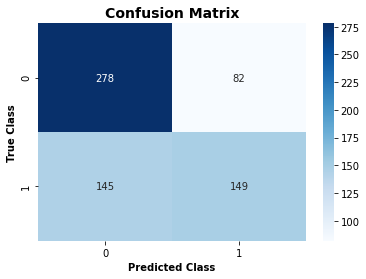

In [104]:
#get test set predictions for best model
y_test_pred =  grid_clf4.predict(X_test)

#print performance metrics on test set
print('Precision score:', precision_score(y_test, y_test_pred).round(3))
print('Recall score:', recall_score(y_test, y_test_pred).round(3))
print('Accuracy score:', accuracy_score(y_test, y_test_pred).round(3))

#print confusion matrix on test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots()
ax = sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues');
ax.set_title('Confusion Matrix', fontsize = 14, fontweight ='bold')
ax.set_xlabel('Predicted Class', fontweight ='bold') 
ax.set_ylabel('True Class', fontweight ='bold')

Based on the highest cross validation accuracy, the Logistic Regression model was chosen as the best model.

The out of sample accuracy achieved was 65.3%.

## Part 2.3 Conclusion
The goal of the project was to see whether one could use the FIFA game data to predict match outcomes. In my analysis I used the home win variable as a proxy for the match outcome.
The baseline model simply predicting the majority class reaches about 55% accuracy. The final model trained best on the highest average cross validation accuracy, in this case a logistic regression model, reached an out of sample accuracy of 65% on the test set.

This is 10% better than simple predicting the majority class, but lower than hoped for. <br>

Potential improvements for future research would be to get better and more frequently updated team specific data, as this was unfortunately not the case in this dataset.

Other improvements could come from using other data sources in combination with the FIFA data, or training more complex models on the challenge such as Neural Networks to achieve a higher accuracy.